# Inventory Monitoring at Distribution Centers

### Problem Statement

Accurate inventory tracking is a primary requirement for modern logistics and fulfillment operations. In such large scale warehouses, each storage bin contains variable quantities of products and incorrect estimates of these products can lead to stockouts, delays and operational inefficiency. Computer vision offers a scalable way to estimate the quantities of items in these bins from the images we get in the warehouse, thereby replacing manual counting.
This Project uses the Amazon Bin Image Dataset, a large scale dataset of warehouse bin images compiled for tasks like classification and quantity understanding. The dataset includes labels such as EXPECTED_QUANTITY and enables building models that can predict the count category from these images.
Modern Deep Learning approaches like CNN that have models pretrained on large scale images like ImageNet that are widely used for efficient transfer learning in Industrial classification tasks. ResNet style architectures are commonly used for such tasks due to its strong performance and stable optimization.
This project builds an end-to-end system that trains a computer vision model to predict the number of items present in a bin image, and deploys it for real-time inference using SageMaker endpoints, with an AWS Lambda function that can trigger predictions from URLs/S3 paths/API Gateway requests.

# ✅Environment check
In this cell we optionally verify that the SageMaker SDK and AWS SDK (boto3) are available.
SageMaker Studio usually includes these by default, but we confirm versions so the project is reproducible.

If this cell fails due to restricted permissions, skip it and proceed — the environment may already be correctly configured.


In [1]:
import sys, subprocess

def pip_install(pkgs):
    cmd = [sys.executable, "-m", "pip", "install", "-q"] + pkgs
    print("Running:", " ".join(cmd))
    subprocess.check_call(cmd)

try:
    import sagemaker, boto3
    print("sagemaker:", sagemaker.__version__)
    print("boto3:", boto3.__version__)
except Exception as e:
    print("SDK import failed, trying install:", repr(e))
    pip_install(["sagemaker", "boto3"])
    import sagemaker, boto3
    print("sagemaker:", sagemaker.__version__)
    print("boto3:", boto3.__version__)

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml
sagemaker: 2.245.0
boto3: 1.37.3


# Imports & Logging
We set up:
- consistent imports
- structured logging (so debugging is easy)
- helper to safely print exceptions

This matters because most early issues are IAM/permissions, bucket access, or wrong region — logging makes these obvious.


In [2]:
import os
import json
import time
import logging
from datetime import datetime

import boto3
import sagemaker
from sagemaker import get_execution_role

# ----- Logging -----
logger = logging.getLogger("capstone")
logger.setLevel(logging.INFO)
if not logger.handlers:
    handler = logging.StreamHandler()
    formatter = logging.Formatter("[%(levelname)s] %(asctime)s - %(message)s")
    handler.setFormatter(formatter)
    logger.addHandler(handler)

def log_exception(msg: str, e: Exception):
    logger.error(f"{msg}: {type(e).__name__} - {e}", exc_info=True)

logger.info("Imports + logging ready.")
logger.info(f"sagemaker={sagemaker.__version__}, boto3={boto3.__version__}")

[INFO] 2025-12-26 07:35:36,338 - Imports + logging ready.
[INFO] 2025-12-26 07:35:36,339 - sagemaker=2.245.0, boto3=1.37.3


# Create SageMaker session, region, role, and default S3 bucket
We create a SageMaker `Session()` which is used throughout the project to:
- upload data to S3
- launch training jobs
- manage outputs/artifacts

We also resolve:
- AWS Region
- Execution Role (permissions used by SageMaker jobs)
- Default bucket (created automatically if needed)

SageMaker’s `default_bucket()` uses a standard naming pattern like:
`sagemaker-{region}-{account-id}` when a bucket is needed and none is specified.
This keeps our project consistent and reproducible across accounts and reviewers.

In [3]:
try:
    # Region
    boto_sess = boto3.session.Session()
    region = boto_sess.region_name
    if not region:
        raise RuntimeError("AWS region not found. Studio should have a region configured.")
    logger.info(f"AWS Region: {region}")

    # SageMaker session
    sm_session = sagemaker.Session(boto_session=boto_sess)
    logger.info("Created SageMaker Session.")

    # Execution role (used by training jobs & deployment)
    role = get_execution_role()
    logger.info(f"Execution Role: {role}")

    # Default S3 bucket used by SageMaker SDK if you don't specify one
    default_bucket = sm_session.default_bucket()
    logger.info(f"Default SageMaker bucket: s3://{default_bucket}")

    # Useful identity info
    sts = boto3.client("sts")
    account_id = sts.get_caller_identity()["Account"]
    logger.info(f"AWS Account ID: {account_id}")

except Exception as e:
    log_exception("Failed creating SageMaker session/role/bucket", e)
    raise

[INFO] 2025-12-26 07:35:38,109 - AWS Region: us-east-1
[INFO] 2025-12-26 07:35:38,246 - Created SageMaker Session.
[INFO] 2025-12-26 07:35:38,393 - Execution Role: arn:aws:iam::354600943736:role/service-role/AmazonSageMaker-ExecutionRole-20251225T115750
[INFO] 2025-12-26 07:35:38,637 - Default SageMaker bucket: s3://sagemaker-us-east-1-354600943736
[INFO] 2025-12-26 07:35:38,731 - AWS Account ID: 354600943736


# Define project S3 prefixes (clean, predictable structure)
We define S3 prefixes that will be used across the project:
- dataset upload locations
- training output locations
- model artifacts
- checkpoints (needed for Managed Spot Training later)

Keeping these paths consistent makes:
- debugging easier
- README/report instructions clearer
- reproduction simpler

In [4]:
PROJECT_NAME = "capstone-bin-count"
RUN_ID = datetime.utcnow().strftime("%Y%m%d-%H%M%S")

# Root prefix for everything in this project
project_prefix = f"{PROJECT_NAME}/{RUN_ID}"

# Data prefixes
s3_data_prefix = f"{project_prefix}/data"
s3_train_prefix = f"{s3_data_prefix}/train"
s3_val_prefix   = f"{s3_data_prefix}/val"
s3_test_prefix  = f"{s3_data_prefix}/test"

# Output prefixes
s3_output_prefix = f"{project_prefix}/output"
s3_checkpoint_prefix = f"{project_prefix}/checkpoints"

def s3_uri(bucket: str, key: str) -> str:
    return f"s3://{bucket}/{key}"

S3_PATHS = {
    "train": s3_uri(default_bucket, s3_train_prefix),
    "val": s3_uri(default_bucket, s3_val_prefix),
    "test": s3_uri(default_bucket, s3_test_prefix),
    "output": s3_uri(default_bucket, s3_output_prefix),
    "checkpoints": s3_uri(default_bucket, s3_checkpoint_prefix),
}

logger.info("S3 paths configured:")
logger.info(json.dumps(S3_PATHS, indent=2))

/tmp/ipykernel_2024/2186079363.py:2: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  RUN_ID = datetime.utcnow().strftime("%Y%m%d-%H%M%S")
[INFO] 2025-12-26 07:35:40,712 - S3 paths configured:
[INFO] 2025-12-26 07:35:40,713 - {
  "train": "s3://sagemaker-us-east-1-354600943736/capstone-bin-count/20251226-073540/data/train",
  "val": "s3://sagemaker-us-east-1-354600943736/capstone-bin-count/20251226-073540/data/val",
  "test": "s3://sagemaker-us-east-1-354600943736/capstone-bin-count/20251226-073540/data/test",
  "output": "s3://sagemaker-us-east-1-354600943736/capstone-bin-count/20251226-073540/output",
  "checkpoints": "s3://sagemaker-us-east-1-354600943736/capstone-bin-count/20251226-073540/checkpoints"
}


# Verify we can access S3
Before we upload data, we verify basic permissions:
- can list the default bucket
- can write/read objects (simple smoke test)

This avoids wasting time later when training fails due to S3/IAM issues.

In [5]:
s3 = boto3.client("s3")

def safe_list_bucket(bucket: str, max_keys: int = 5):
    resp = s3.list_objects_v2(Bucket=bucket, MaxKeys=max_keys)
    keys = [obj["Key"] for obj in resp.get("Contents", [])]
    return keys

try:
    existing_keys = safe_list_bucket(default_bucket, max_keys=5)
    logger.info(f"✅ Can list bucket s3://{default_bucket}. Sample keys: {existing_keys}")

    # Write a tiny object (smoke test)
    test_key = f"{project_prefix}/_smoke_test.txt"
    s3.put_object(Bucket=default_bucket, Key=test_key, Body=b"smoke-test")
    logger.info(f"✅ Wrote smoke test object: s3://{default_bucket}/{test_key}")

    # Read it back
    obj = s3.get_object(Bucket=default_bucket, Key=test_key)
    content = obj["Body"].read().decode("utf-8")
    logger.info(f"✅ Read back content: {content}")

except Exception as e:
    log_exception("S3 permission check failed", e)
    raise

[INFO] 2025-12-26 07:35:44,744 - ✅ Can list bucket s3://sagemaker-us-east-1-354600943736. Sample keys: ['capstone-bin-count-baseline-20251225-063820/source/sourcedir.tar.gz', 'capstone-bin-count-baseline-20251225-090040/source/sourcedir.tar.gz', 'capstone-bin-count-hpo-20251225-094839/source/sourcedir.tar.gz', 'capstone-bin-count/20251225-063820/_smoke_test.txt', 'capstone-bin-count/20251225-063820/checkpoints/ddp/checkpoint.pt']
[INFO] 2025-12-26 07:35:44,770 - ✅ Wrote smoke test object: s3://sagemaker-us-east-1-354600943736/capstone-bin-count/20251226-073540/_smoke_test.txt
[INFO] 2025-12-26 07:35:44,792 - ✅ Read back content: smoke-test


# Data acquisition + S3 upload (ImageFolder format)
In this step we:
1) Download the required images from the public Amazon Bin Image Dataset S3 bucket (`aft-vbi-pds`).
2) Arrange them into an ImageFolder-compatible structure:
   train/<class>/..., val/<class>/..., test/<class>/...
   where class is the object-count label: 1,2,3,4,5
3) Upload each split to our SageMaker default bucket using `sagemaker.Session().upload_data(...)`.

Why this structure?
- `torchvision.datasets.ImageFolder` expects images to be organized as `<split>/<class_name>/<image files>`.
- This makes `train.py` simple and reliable.

In [6]:
import os
import json
import random
import shutil
from pathlib import Path

import boto3
from botocore.config import Config
from tqdm import tqdm

# ---- Source dataset (public Open Data on AWS) ----
ABID_BUCKET = "aft-vbi-pds"
ABID_REGION = "us-east-1"  # dataset bucket region is listed as us-east-1
ABID_IMAGES_PREFIX = "bin-images"  # images live under this prefix

# ---- Local workspace ----
LOCAL_ROOT = Path("./local_data")
RAW_DIR = LOCAL_ROOT / "raw_by_class"     # raw downloaded images grouped by label
SPLIT_DIR = LOCAL_ROOT / "splits"         # final ImageFolder structure

TRAIN_DIR = SPLIT_DIR / "train"
VAL_DIR   = SPLIT_DIR / "val"
TEST_DIR  = SPLIT_DIR / "test"

# ---- Split ratios ----
SEED = 42
TRAIN_RATIO = 0.80
VAL_RATIO = 0.10
TEST_RATIO = 0.10

assert abs((TRAIN_RATIO + VAL_RATIO + TEST_RATIO) - 1.0) < 1e-9

# Optional: for a quick smoke test, set a small number like 50 (per class).
# For full run, keep as None.
MAX_PER_CLASS = None

# The Udacity file that lists which metadata IDs belong to each class label (1..5)
FILE_LIST_PATH = Path("./file_list.json")

print("Config ready.")
print("Local root:", LOCAL_ROOT.resolve())
print("File list path exists?", FILE_LIST_PATH.exists())

Config ready.
Local root: /home/sagemaker-user/local_data
File list path exists? True


# Diagnose why we get 403 (S3 API vs HTTP vs wrong keys)
We test 2 access paths to the ABID bucket:
1) S3 API access via boto3 UNSIGNED (like `aws s3 --no-sign-request`)
2) Direct HTTPS access via requests to the public bucket URL

We test TWO keys:
- 559.jpg (the example that is often used in tutorials)
- 100313.jpg (from your failure list)

Interpretation:
- If HTTPS works but boto3 fails -> S3 API access is blocked in the environment, so use HTTPS download.
- If both fail -> keys might be wrong OR access is restricted. We'll then try the "strip leading zeros" fix and/or AWS CLI fallback.

In [13]:
import requests
from botocore.client import Config
from botocore import UNSIGNED
import boto3

ABID_BUCKET = "aft-vbi-pds"
ABID_REGION = "us-east-1"

test_keys = [
    "bin-images/559.jpg",
    "bin-images/100313.jpg",
]

# 1) boto3 unsigned client
s3_unsigned = boto3.client(
    "s3",
    region_name=ABID_REGION,
    config=Config(signature_version=UNSIGNED)
)

print("=== Testing boto3 UNSIGNED (S3 API) ===")
for k in test_keys:
    try:
        s3_unsigned.head_object(Bucket=ABID_BUCKET, Key=k)
        print(f"✅ head_object OK: {k}")
    except Exception as e:
        print(f"❌ head_object FAIL: {k} -> {type(e).__name__}: {e}")

print("\n=== Testing HTTPS (public URL) ===")
for k in test_keys:
    url = f"https://{ABID_BUCKET}.s3.amazonaws.com/{k}"
    try:
        r = requests.get(url, timeout=20)
        print(f"{url} -> HTTP {r.status_code}, bytes={len(r.content)}")
    except Exception as e:
        print(f"❌ HTTPS FAIL: {url} -> {type(e).__name__}: {e}")

=== Testing boto3 UNSIGNED (S3 API) ===
✅ head_object OK: bin-images/559.jpg
✅ head_object OK: bin-images/100313.jpg

=== Testing HTTPS (public URL) ===
https://aft-vbi-pds.s3.amazonaws.com/bin-images/559.jpg -> HTTP 200, bytes=42630
https://aft-vbi-pds.s3.amazonaws.com/bin-images/100313.jpg -> HTTP 200, bytes=34379


# Download images from the public ABID S3 bucket
`file_list.json` maps each class label (1..5) to a list of metadata JSON paths like:
  data/metadata/100313.json

We convert each metadata file name to its image name:
  100313.json  ->  100313.jpg

Then we download:
  s3://aft-vbi-pds/bin-images/100313.jpg

We download into:
  local_data/raw_by_class/<label>/<image>.jpg

Note:
- The ABID dataset is hosted as an AWS Open Data S3 bucket (`aft-vbi-pds`) in us-east-1.
- We'll use boto3's `download_file()` to fetch objects.

Robust ABID download (UNSIGNED + get_object streaming + leading-zero fallback)
Why we change the approach:
- `boto3.download_file()` internally calls `HeadObject` before downloading.
- `HeadObject` can return 403 if the key doesn't exist AND you don't have ListBucket permissions.
  AWS documents this 403/404 behavior. (So 403 does NOT always mean "bucket is blocked".)
- To avoid the HeadObject pre-check, we download via `get_object()` streaming.

We also handle possible filename mismatch:
- If metadata file is `00710.json`, the actual image key might be `00710.jpg` OR `710.jpg`.
- We try both forms.

Output:
- Downloads images into: local_data/raw_by_class/<label>/<filename>.jpg

In [14]:
import json
from pathlib import Path

import boto3
from botocore.config import Config
from botocore import UNSIGNED
from botocore.exceptions import ClientError

# ---- Source dataset (Open Data bucket) ----
ABID_BUCKET = "aft-vbi-pds"
ABID_REGION = "us-east-1"
ABID_IMAGES_PREFIX = "bin-images"

# ---- Local workspace ----
LOCAL_ROOT = Path("./local_data")
RAW_DIR = LOCAL_ROOT / "raw_by_class"
RAW_DIR.mkdir(parents=True, exist_ok=True)

# ---- File list ----
FILE_LIST_PATH = Path("./file_list.json")
with open(FILE_LIST_PATH, "r") as f:
    file_map = json.load(f)

SEED = 42
random.seed(SEED)

# Optional: for quick testing set like 50, else None for full run
MAX_PER_CLASS = None

# ✅ UNSIGNED client (anonymous access for Open Data bucket)
s3_unsigned = boto3.client(
    "s3",
    region_name=ABID_REGION,
    config=Config(signature_version=UNSIGNED, retries={"max_attempts": 10, "mode": "standard"})
)

def meta_path_to_stem(meta_path: str) -> str:
    # "data/metadata/00710.json" -> "00710"
    return os.path.splitext(os.path.basename(meta_path))[0]

def candidate_filenames(stem: str):
    """
    Try:
      stem.jpg  (preserves leading zeros)
      int(stem).jpg (strips leading zeros)
    """
    cands = [f"{stem}.jpg"]
    try:
        cands.append(f"{int(stem)}.jpg")
    except Exception:
        pass
    # De-duplicate while preserving order
    out = []
    for c in cands:
        if c not in out:
            out.append(c)
    return out

def download_via_get_object(bucket: str, key: str, out_path: Path) -> bool:
    """
    Stream object bytes to disk using get_object() (avoids HeadObject pre-check).
    Returns True if downloaded successfully, False otherwise.
    """
    try:
        resp = s3_unsigned.get_object(Bucket=bucket, Key=key)
        body = resp["Body"]
        out_path.parent.mkdir(parents=True, exist_ok=True)
        with open(out_path, "wb") as f:
            for chunk in iter(lambda: body.read(1024 * 1024), b""):
                f.write(chunk)
        return True
    except ClientError as e:
        # 403/404 etc. are expected for bad keys; we'll try fallback candidates
        return False

# Quick sanity check (should succeed given your diagnostics)
for sanity_key in ["bin-images/559.jpg", "bin-images/100313.jpg"]:
    try:
        s3_unsigned.head_object(Bucket=ABID_BUCKET, Key=sanity_key)
    except Exception as e:
        raise RuntimeError(f"Sanity check failed for {sanity_key}: {e}")

downloaded = 0
skipped = 0
failed = []

for label, meta_paths in file_map.items():
    label_dir = RAW_DIR / str(label)
    label_dir.mkdir(parents=True, exist_ok=True)

    chosen = meta_paths[:MAX_PER_CLASS] if MAX_PER_CLASS else meta_paths
    print(f"\nDownloading class={label} images: {len(chosen)} files")

    for meta_path in tqdm(chosen):
        stem = meta_path_to_stem(meta_path)

        # If already exists (either naming variant), skip
        already = False
        for fname in candidate_filenames(stem):
            p = label_dir / fname
            if p.exists() and p.stat().st_size > 0:
                skipped += 1
                already = True
                break
        if already:
            continue

        # Try candidates
        ok = False
        for fname in candidate_filenames(stem):
            key = f"{ABID_IMAGES_PREFIX}/{fname}"
            out_path = label_dir / fname
            if download_via_get_object(ABID_BUCKET, key, out_path):
                downloaded += 1
                ok = True
                break

        if not ok:
            failed.append((label, stem))

print("\nDownload summary:")
print("Downloaded:", downloaded)
print("Skipped (already existed):", skipped)
print("Failed:", len(failed))

if failed:
    print("\nFirst 20 failures:", failed[:20])
    raise RuntimeError("Some downloads failed. Usually this means those keys don't exist in the bucket.")

100%|██████████| 1228/1228 [01:06<00:00, 18.41it/s]


100%|██████████| 2299/2299 [02:08<00:00, 17.96it/s]


100%|██████████| 2666/2666 [02:33<00:00, 17.37it/s]


100%|██████████| 2373/2373 [02:12<00:00, 17.88it/s]


100%|██████████| 1875/1875 [01:42<00:00, 18.32it/s]


Download summary:
Downloaded: 10438
Skipped (already existed): 3
Failed: 0


# Create stratified train/val/test splits (ImageFolder format)
Now that we have all images locally in `raw_by_class/<label>/...`,
we create final folders:

  local_data/splits/train/1/...
  local_data/splits/val/1/...
  local_data/splits/test/1/...
  ... similarly for labels 2..5

We do stratified sampling by operating per-class:
- shuffle within each class (seeded)
- split into train/val/test with the configured ratios

This produces a clean, deterministic split that is replicable.

In [15]:
# Clean old splits (optional but recommended for reruns)
if SPLIT_DIR.exists():
    shutil.rmtree(SPLIT_DIR)

for split_base in [TRAIN_DIR, VAL_DIR, TEST_DIR]:
    split_base.mkdir(parents=True, exist_ok=True)

random.seed(SEED)

def split_list(items, train_ratio, val_ratio):
    """
    Split list into train/val/test by ratios.
    """
    n = len(items)
    n_train = int(n * train_ratio)
    n_val = int(n * val_ratio)
    # remainder goes to test
    train_items = items[:n_train]
    val_items = items[n_train:n_train + n_val]
    test_items = items[n_train + n_val:]
    return train_items, val_items, test_items

summary = {}

for label in sorted(file_map.keys(), key=int):
    src_dir = RAW_DIR / str(label)
    images = sorted([p for p in src_dir.glob("*.jpg")])

    if not images:
        raise RuntimeError(f"No images found for label={label} in {src_dir}")

    random.shuffle(images)

    train_imgs, val_imgs, test_imgs = split_list(images, TRAIN_RATIO, VAL_RATIO)

    # Create target label folders
    for base in [TRAIN_DIR, VAL_DIR, TEST_DIR]:
        (base / str(label)).mkdir(parents=True, exist_ok=True)

    # Copy files (copy is safer than move for reruns/debug)
    for p in train_imgs:
        shutil.copy2(p, TRAIN_DIR / str(label) / p.name)
    for p in val_imgs:
        shutil.copy2(p, VAL_DIR / str(label) / p.name)
    for p in test_imgs:
        shutil.copy2(p, TEST_DIR / str(label) / p.name)

    summary[label] = {"train": len(train_imgs), "val": len(val_imgs), "test": len(test_imgs)}

print("Split summary per class:")
print(json.dumps(summary, indent=2))

total_train = sum(v["train"] for v in summary.values())
total_val   = sum(v["val"] for v in summary.values())
total_test  = sum(v["test"] for v in summary.values())

print("\nTotals:", {"train": total_train, "val": total_val, "test": total_test, "all": total_train + total_val + total_test})

Split summary per class:
{
  "1": {
    "train": 982,
    "val": 122,
    "test": 124
  },
  "2": {
    "train": 1839,
    "val": 229,
    "test": 231
  },
  "3": {
    "train": 2132,
    "val": 266,
    "test": 268
  },
  "4": {
    "train": 1898,
    "val": 237,
    "test": 238
  },
  "5": {
    "train": 1497,
    "val": 187,
    "test": 188
  }
}

Totals: {'train': 8348, 'val': 1041, 'test': 1049, 'all': 10438}


# Upload train/val/test folders to S3 using SageMaker Session
We upload the ImageFolder structure to S3 using SageMaker's `Session.upload_data()`.

This is the standard SageMaker pattern:
- data lives in S3
- training jobs consume S3 URIs via channels like "training", "validation", "test"

After upload, we print the resulting S3 URIs.
These will be used in Milestone 2 (deep analysis on the uploaded dataset) and later for model training.


In [16]:
# Sanity checks
for p in [TRAIN_DIR, VAL_DIR, TEST_DIR]:
    if not p.exists():
        raise RuntimeError(f"Missing split folder: {p}")

print("Uploading to S3... This may take a while depending on dataset size.")

# Upload each split to its configured prefix
s3_train_uri = sm_session.upload_data(path=str(TRAIN_DIR), bucket=default_bucket, key_prefix=s3_train_prefix)
s3_val_uri   = sm_session.upload_data(path=str(VAL_DIR),   bucket=default_bucket, key_prefix=s3_val_prefix)
s3_test_uri  = sm_session.upload_data(path=str(TEST_DIR),  bucket=default_bucket, key_prefix=s3_test_prefix)

print("\n✅ Upload complete.")
print("Train S3 URI:", s3_train_uri)
print("Val S3 URI:  ", s3_val_uri)
print("Test S3 URI: ", s3_test_uri)

# Overwrite our S3_PATHS dict to ensure it matches the uploaded URIs
S3_PATHS["train"] = s3_train_uri
S3_PATHS["val"] = s3_val_uri
S3_PATHS["test"] = s3_test_uri

print("\nS3_PATHS updated:")
print(json.dumps(S3_PATHS, indent=2))

Uploading to S3... This may take a while depending on dataset size.

✅ Upload complete.
Train S3 URI: s3://sagemaker-us-east-1-354600943736/capstone-bin-count/20251225-063820/data/train
Val S3 URI:   s3://sagemaker-us-east-1-354600943736/capstone-bin-count/20251225-063820/data/val
Test S3 URI:  s3://sagemaker-us-east-1-354600943736/capstone-bin-count/20251225-063820/data/test

S3_PATHS updated:
{
  "train": "s3://sagemaker-us-east-1-354600943736/capstone-bin-count/20251225-063820/data/train",
  "val": "s3://sagemaker-us-east-1-354600943736/capstone-bin-count/20251225-063820/data/val",
  "test": "s3://sagemaker-us-east-1-354600943736/capstone-bin-count/20251225-063820/data/test",
  "output": "s3://sagemaker-us-east-1-354600943736/capstone-bin-count/20251225-063820/output",
  "checkpoints": "s3://sagemaker-us-east-1-354600943736/capstone-bin-count/20251225-063820/checkpoints"
}


# Verify upload worked by counting S3 objects
We do a quick validation:
- list objects under each uploaded prefix
- count how many `.jpg` files exist

This confirms the dataset is truly in S3 and ready for analysis.

In [17]:
import re

s3 = boto3.client("s3")

def parse_s3_uri(uri: str):
    m = re.match(r"s3://([^/]+)/(.+)", uri)
    if not m:
        raise ValueError(f"Not a valid s3 uri: {uri}")
    return m.group(1), m.group(2).rstrip("/") + "/"

def count_jpg_objects(s3_uri: str) -> int:
    bucket, prefix = parse_s3_uri(s3_uri)
    paginator = s3.get_paginator("list_objects_v2")
    total = 0
    for page in paginator.paginate(Bucket=bucket, Prefix=prefix):
        for obj in page.get("Contents", []):
            if obj["Key"].lower().endswith(".jpg"):
                total += 1
    return total

counts = {
    "train_jpg": count_jpg_objects(S3_PATHS["train"]),
    "val_jpg": count_jpg_objects(S3_PATHS["val"]),
    "test_jpg": count_jpg_objects(S3_PATHS["test"]),
}
counts["total"] = counts["train_jpg"] + counts["val_jpg"] + counts["test_jpg"]

print("✅ S3 counts:", counts)

✅ S3 counts: {'train_jpg': 8348, 'val_jpg': 1041, 'test_jpg': 1049, 'total': 10438}


# Deep analysis (from S3, before training)
we analyze the dataset *after upload to S3* and *before training*.

We will:
1) Enumerate the S3 dataset structure and compute:
   - image counts per split and per class (1–5)
   - missing/extra counts vs the expected file_list.json totals
   - file-size statistics (helps catch broken uploads)
2) Sample images directly from S3 and compute:
   - image resolution statistics (width/height)
   - basic quality checks (corrupt or unreadable images)
3) Create visualizations:
   - class distribution (train/val/test)
   - sample image grids by class
4) Define benchmarks:
   - majority-class baseline accuracy
   - random-guess baseline accuracy

We intentionally use SageMaker-native variables:
- `sm_session`, `default_bucket`, and `S3_PATHS`

In [18]:
import random
from pathlib import Path
from collections import defaultdict

import boto3
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

# Reuse the same boto3 session and SageMaker session already created
s3 = sm_session.boto_session.client("s3")

random.seed(42)
np.random.seed(42)

def parse_s3_uri(uri: str):
    m = re.match(r"s3://([^/]+)/(.+)", uri)
    if not m:
        raise ValueError(f"Invalid S3 URI: {uri}")
    return m.group(1), m.group(2).rstrip("/") + "/"

train_bucket, train_prefix = parse_s3_uri(S3_PATHS["train"])
val_bucket, val_prefix     = parse_s3_uri(S3_PATHS["val"])
test_bucket, test_prefix   = parse_s3_uri(S3_PATHS["test"])

assert train_bucket == val_bucket == test_bucket, "All splits should be in same bucket for simplicity."
DATA_BUCKET = train_bucket

print("Dataset bucket:", DATA_BUCKET)
print("Train prefix:", train_prefix)
print("Val prefix:  ", val_prefix)
print("Test prefix: ", test_prefix)

def list_objects(bucket: str, prefix: str):
    """
    Returns generator of S3 objects dict: Key, Size, LastModified, etc.
    """
    paginator = s3.get_paginator("list_objects_v2")
    for page in paginator.paginate(Bucket=bucket, Prefix=prefix):
        for obj in page.get("Contents", []):
            yield obj

Dataset bucket: sagemaker-us-east-1-354600943736
Train prefix: capstone-bin-count/20251225-063820/data/train/
Val prefix:   capstone-bin-count/20251225-063820/data/val/
Test prefix:  capstone-bin-count/20251225-063820/data/test/


# S3-based counts per split and class + size stats
We compute:
- number of .jpg files per split and per class (1..5)
- total bytes per split (rough dataset size)

We infer class label from S3 key structure:
  <prefix>/<class>/<filename>.jpg

This checks:
- upload correctness
- missing classes
- unexpected file types

In [19]:
def split_class_counts(bucket: str, split_prefix: str):
    counts = defaultdict(int)
    sizes = defaultdict(int)
    total_files = 0
    total_bytes = 0
    non_jpg = 0

    for obj in list_objects(bucket, split_prefix):
        key = obj["Key"]
        size = obj["Size"]

        if not key.lower().endswith(".jpg"):
            non_jpg += 1
            continue

        # Extract class label: prefix/<class>/file.jpg
        rel = key[len(split_prefix):]  # e.g., "3/123.jpg"
        parts = rel.split("/")
        if len(parts) < 2:
            continue

        label = parts[0]
        counts[label] += 1
        sizes[label] += size
        total_files += 1
        total_bytes += size

    return {
        "counts": dict(counts),
        "sizes": dict(sizes),
        "total_files": total_files,
        "total_bytes": total_bytes,
        "non_jpg": non_jpg
    }

train_stats = split_class_counts(DATA_BUCKET, train_prefix)
val_stats   = split_class_counts(DATA_BUCKET, val_prefix)
test_stats  = split_class_counts(DATA_BUCKET, test_prefix)

print("Train:", train_stats["total_files"], "images,", round(train_stats["total_bytes"]/1e6, 2), "MB")
print("Val:  ", val_stats["total_files"], "images,", round(val_stats["total_bytes"]/1e6, 2), "MB")
print("Test: ", test_stats["total_files"], "images,", round(test_stats["total_bytes"]/1e6, 2), "MB")

print("\nCounts by class:")
print("Train:", train_stats["counts"])
print("Val:  ", val_stats["counts"])
print("Test: ", test_stats["counts"])

Train: 8348 images, 491.69 MB
Val:   1041 images, 61.61 MB
Test:  1049 images, 61.09 MB

Counts by class:
Train: {'1': 982, '2': 1839, '3': 2132, '4': 1898, '5': 1497}
Val:   {'1': 122, '2': 229, '3': 266, '4': 237, '5': 187}
Test:  {'1': 124, '2': 231, '3': 268, '4': 238, '5': 188}


# Validate uploaded counts vs expected file_list.json totals (anomaly detection)
We compare:
- expected total images from file_list.json
vs
- actual total images present in S3 (train+val+test)

If there is a mismatch, we record it as a dataset abnormality.
Common causes:
- a few keys were missing from the source bucket
- a few downloads failed
- a few files were corrupted and skipped during processing

In [20]:
FILE_LIST_PATH = Path("./file_list.json")
with open(FILE_LIST_PATH, "r") as f:
    file_map = json.load(f)

expected_per_class = {k: len(v) for k, v in file_map.items()}
expected_total = sum(expected_per_class.values())

actual_per_class = defaultdict(int)
for lbl, cnt in train_stats["counts"].items():
    actual_per_class[lbl] += cnt
for lbl, cnt in val_stats["counts"].items():
    actual_per_class[lbl] += cnt
for lbl, cnt in test_stats["counts"].items():
    actual_per_class[lbl] += cnt

actual_total = train_stats["total_files"] + val_stats["total_files"] + test_stats["total_files"]

print("Expected per class:", expected_per_class)
print("Actual per class:   ", dict(actual_per_class))
print("\nExpected total:", expected_total)
print("Actual total:  ", actual_total)
print("Difference:    ", expected_total - actual_total)

missing_by_class = {k: expected_per_class[k] - actual_per_class.get(k, 0) for k in expected_per_class.keys()}
print("\nMissing by class (expected - actual):")
print(missing_by_class)

# Simple anomaly flags
if expected_total != actual_total:
    print("\n⚠️ ANOMALY: Uploaded total != expected total. We'll mention this in the report.")
else:
    print("\n✅ No count mismatch between expected and uploaded dataset.")

Expected per class: {'1': 1228, '2': 2299, '3': 2666, '4': 2373, '5': 1875}
Actual per class:    {'1': 1228, '2': 2299, '3': 2666, '4': 2373, '5': 1872}

Expected total: 10441
Actual total:   10438
Difference:     3

Missing by class (expected - actual):
{'1': 0, '2': 0, '3': 0, '4': 0, '5': 3}

⚠️ ANOMALY: Uploaded total != expected total. We'll mention this in the report.


# Sample images from S3 to compute resolution stats + corruption checks
We download a small sample of images per class from the *training split* and:
- open with PIL to get (width, height)
- attempt `.verify()` to catch corrupted images
- report failure count

This helps us:
- confirm images are readable
- understand resolution variability
- anticipate preprocessing needs (resize/crop)

In [21]:
SAMPLE_PER_CLASS = 25  # keep small; enough for stats + visuals
SAMPLE_DIR = Path("./eda_samples")
SAMPLE_DIR.mkdir(parents=True, exist_ok=True)

def collect_keys_for_class(split_prefix: str, label: str, max_keys: int = 50):
    keys = []
    prefix = f"{split_prefix}{label}/"
    for obj in list_objects(DATA_BUCKET, prefix):
        k = obj["Key"]
        if k.lower().endswith(".jpg"):
            keys.append(k)
            if len(keys) >= max_keys:
                break
    return keys

def download_key_to_local(key: str, out_path: Path):
    out_path.parent.mkdir(parents=True, exist_ok=True)
    # Using download_file here is fine for *our* bucket (we have permissions)
    s3.download_file(DATA_BUCKET, key, str(out_path))

resolutions = defaultdict(list)
corrupt = []

for label in sorted(train_stats["counts"].keys(), key=int):
    keys = collect_keys_for_class(train_prefix, label, max_keys=500)
    if not keys:
        print(f"No keys found for label={label}")
        continue

    sampled = random.sample(keys, k=min(SAMPLE_PER_CLASS, len(keys)))
    for k in sampled:
        fname = k.split("/")[-1]
        local_path = SAMPLE_DIR / label / fname
        if not local_path.exists():
            download_key_to_local(k, local_path)

        try:
            with Image.open(local_path) as img:
                img.verify()  # validate file integrity
            with Image.open(local_path) as img2:
                w, h = img2.size
            resolutions[label].append((w, h))
        except Exception as e:
            corrupt.append((label, k, str(e)))

print("Sampled resolution counts:", {k: len(v) for k, v in resolutions.items()})
print("Corrupt/Unreadable samples:", len(corrupt))
if corrupt:
    print("First 5 corrupt samples:", corrupt[:5])

# Compute basic resolution summary
for label, wh in resolutions.items():
    w = [x[0] for x in wh]
    h = [x[1] for x in wh]
    print(f"Label={label}: width mean={np.mean(w):.1f}, min={np.min(w)}, max={np.max(w)} | height mean={np.mean(h):.1f}, min={np.min(h)}, max={np.max(h)}")

Sampled resolution counts: {'1': 25, '2': 25, '3': 25, '4': 25, '5': 25}
Corrupt/Unreadable samples: 0
Label=1: width mean=459.6, min=357, max=708 | height mean=397.9, min=244, max=635
Label=2: width mean=454.3, min=321, max=699 | height mean=394.8, min=252, max=948
Label=3: width mean=516.0, min=334, max=717 | height mean=448.0, min=247, max=971
Label=4: width mean=471.6, min=363, max=681 | height mean=432.2, min=253, max=652
Label=5: width mean=493.2, min=328, max=726 | height mean=429.2, min=248, max=984


# Exploratory Visualization — Class distribution across splits
We visualize the class distribution for train/val/test to:
- confirm class imbalance
- justify macro F1 (accuracy alone can be misleading on imbalanced data)
- provide clear evidence in the report/README

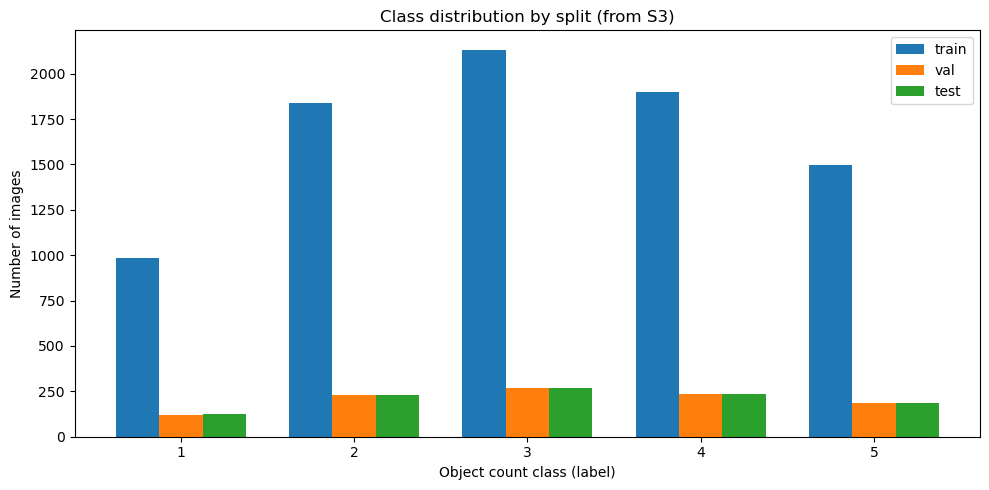

Train class proportions: {'1': 0.1176, '2': 0.2203, '3': 0.2554, '4': 0.2274, '5': 0.1793}
Imbalance ratio (max/min): 2.17


In [22]:
classes = [str(i) for i in range(1, 6)]

train_counts = [train_stats["counts"].get(c, 0) for c in classes]
val_counts   = [val_stats["counts"].get(c, 0) for c in classes]
test_counts  = [test_stats["counts"].get(c, 0) for c in classes]

x = np.arange(len(classes))
width = 0.25

plt.figure(figsize=(10, 5))
plt.bar(x - width, train_counts, width, label="train")
plt.bar(x,         val_counts,   width, label="val")
plt.bar(x + width, test_counts,  width, label="test")
plt.xticks(x, classes)
plt.xlabel("Object count class (label)")
plt.ylabel("Number of images")
plt.title("Class distribution by split (from S3)")
plt.legend()
plt.tight_layout()
plt.show()

# Helpful imbalance metric
total_train = sum(train_counts)
train_props = [c/total_train for c in train_counts]
print("Train class proportions:", dict(zip(classes, [round(p, 4) for p in train_props])))
print("Imbalance ratio (max/min):", round(max(train_counts)/max(1, min(train_counts)), 2))

# Exploratory Visualization — Sample images per class
We plot a small grid of sample images from each class to visually inspect:
- occlusion and clutter in bins
- lighting variations
- object overlap and scale differences

This supports our choice of a CNN with transfer learning.

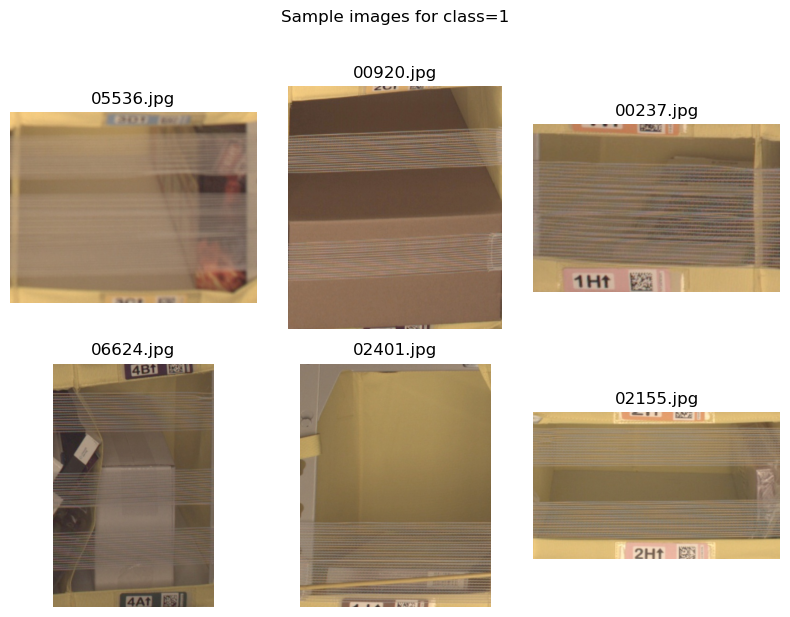

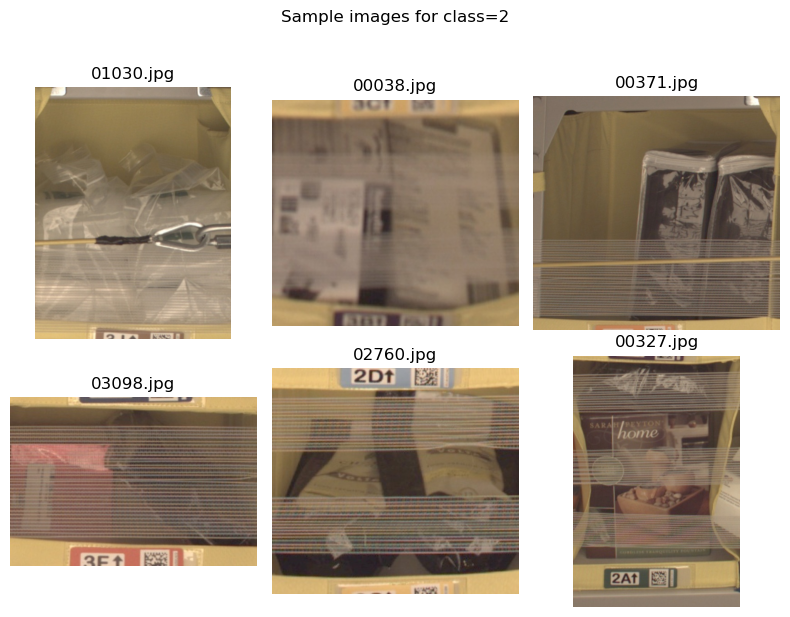

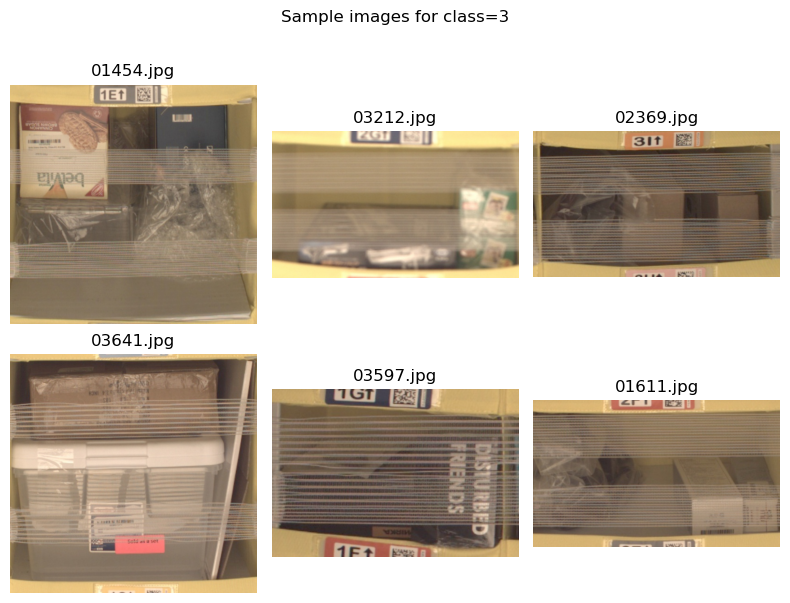

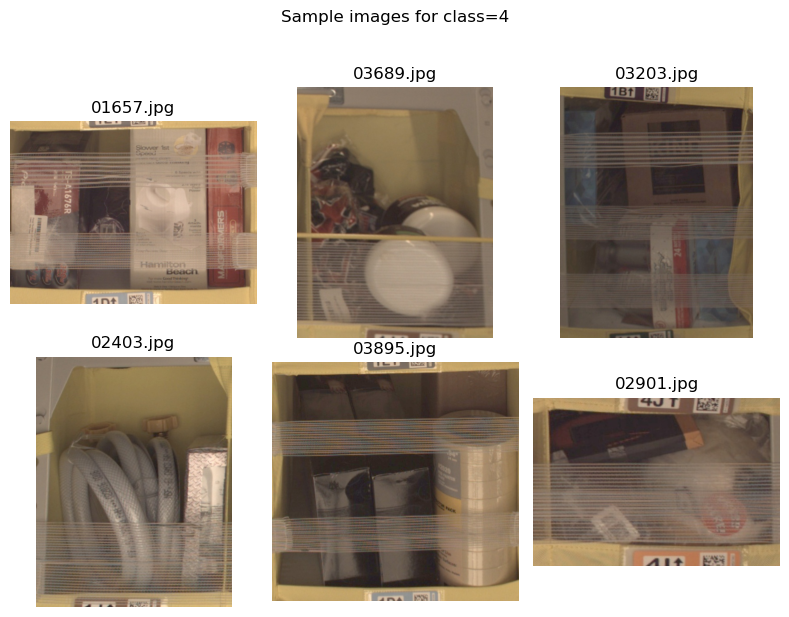

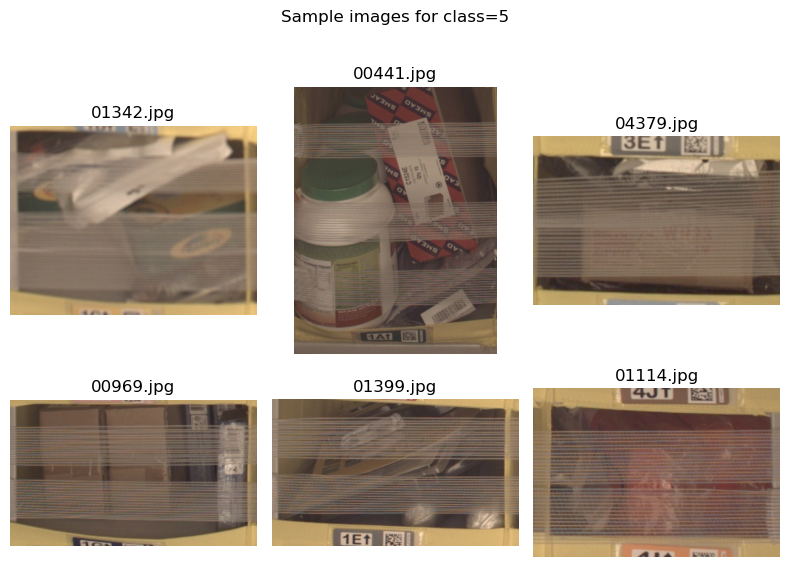

In [23]:
def show_image_grid(label: str, max_images: int = 9):
    label_dir = SAMPLE_DIR / label
    imgs = list(label_dir.glob("*.jpg"))
    if not imgs:
        print(f"No sample images found for label={label}. Run the sampling cell first.")
        return
    imgs = imgs[:max_images]

    cols = 3
    rows = int(np.ceil(len(imgs) / cols))
    plt.figure(figsize=(8, 3*rows))

    for i, p in enumerate(imgs):
        plt.subplot(rows, cols, i+1)
        img = Image.open(p)
        plt.imshow(img)
        plt.axis("off")
        plt.title(p.name)

    plt.suptitle(f"Sample images for class={label}", y=1.02)
    plt.tight_layout()
    plt.show()

for lbl in classes:
    show_image_grid(lbl, max_images=6)

# Benchmarks + model/metric choices (pre-training)
### Benchmark
We define two simple, measurable benchmarks:

1) Majority-class baseline (most frequent class in the test set):
   - Predict that class for every test image
   - Baseline Accuracy = (#images in majority class) / (total test images)

2) Random-guess baseline (uniform across 5 classes):
   - Expected Accuracy ≈ 1/5 = 0.20

These baselines are reproducible and provide a threshold the trained model must exceed.

### Algorithms & Techniques (why CNN transfer learning)
We will use a pretrained CNN (ResNet) fine-tuned for 5-class classification because:
- the input is images with complex textures and occlusions
- pretrained CNNs learn strong visual features and reduce training time
- ImageFolder + transforms provides a clean and standard pipeline

### Metrics
We will track:
- Accuracy (easy to interpret)
- Macro F1 (important for imbalanced classes: treats each class equally)
- Confusion Matrix (to see which counts get confused)

In [24]:
test_total = test_stats["total_files"]
test_counts_dict = test_stats["counts"]

majority_class = max(test_counts_dict.items(), key=lambda x: x[1])[0]
majority_count = test_counts_dict[majority_class]
majority_acc = majority_count / max(1, test_total)

random_acc = 1.0 / 5.0

print("=== Benchmark Results (computed from S3 test split) ===")
print("Test total images:", test_total)
print("Majority class:", majority_class)
print("Majority class count:", majority_count)
print("Majority-class baseline accuracy:", round(majority_acc, 4))
print("Uniform random baseline accuracy (expected):", round(random_acc, 4))

# Define a target threshold (example): beat majority baseline by a healthy margin
target_acc = min(0.95, majority_acc + 0.15)
print("\nSuggested benchmark threshold to claim improvement:", round(target_acc, 4))

=== Benchmark Results (computed from S3 test split) ===
Test total images: 1049
Majority class: 3
Majority class count: 268
Majority-class baseline accuracy: 0.2555
Uniform random baseline accuracy (expected): 0.2

Suggested benchmark threshold to claim improvement: 0.4055


# Implement train.py (SageMaker Script Mode compatible)
Here we are going to replace the starter `train.py` with a complete training script that:

1) Loads image data from SageMaker input channels:
   - SM_CHANNEL_TRAINING
   - SM_CHANNEL_VALIDATION
   - SM_CHANNEL_TEST
   (These folders are created automatically inside the training container from the S3 URIs we pass in `estimator.fit()`.)

2) Uses transfer learning with a pretrained ResNet-50 and replaces the final layer for 5 classes (1..5).

3) Logs metrics to stdout in a regex-friendly format so SageMaker can capture them
   (required later for hyperparameter tuning / CloudWatch metrics).

4) Saves `model.pth` into SM_MODEL_DIR so SageMaker collects it as the model artifact.

5) Includes optional SageMaker Debugger (smdebug) hooks for debugging/profiling if configured.

References:
- SageMaker PyTorch Script Mode patterns: training script + estimator `fit()` channels. 
- Defining training metrics using regex from logs.
- Adding Debugger hooks to a PyTorch script.

Checkout the `train.py` file directly to understand this

# local smoke test (1 batch)
Before launching a paid SageMaker training job, we run a quick smoke test locally:
- loads ImageFolder from local splits (if present)
- runs one forward/backward step
This verifies:
- file paths are correct
- model builds
- data loaders and transforms work
- loss/optimizer setup is correct

If you don't have local splits anymore, this will tell you and you can skip it.
(Training in SageMaker will still work using S3 channels later.)

In [25]:
local_train = Path("./local_data/splits/train")
local_val   = Path("./local_data/splits/val")
local_test  = Path("./local_data/splits/test")

if local_train.exists() and local_val.exists() and local_test.exists():
    cmd = [
        sys.executable, "train.py",
        "--smoke_test",
        "--train_dir", str(local_train),
        "--val_dir", str(local_val),
        "--test_dir", str(local_test),
        "--batch_size", "8",
        "--learning_rate", "0.001"
    ]
    print("Running:", " ".join(cmd))
    subprocess.check_call(cmd)
    print("✅ Smoke test passed.")
else:
    print("Local split folders not found. Skipping smoke test.")
    print("Expected:", local_train, local_val, local_test)

Running: /opt/conda/bin/python train.py --smoke_test --train_dir local_data/splits/train --val_dir local_data/splits/val --test_dir local_data/splits/test --batch_size 8 --learning_rate 0.001
Args: Namespace(epochs=5, batch_size=8, learning_rate=0.001, weight_decay=0.0, freeze_backbone=True, early_stop_patience=3, num_workers=2, train_dir='local_data/splits/train', val_dir='local_data/splits/val', test_dir='local_data/splits/test', model_dir='/opt/ml/model', smoke_test=True)
Using device: cpu
Classes (ImageFolder): ['1', '2', '3', '4', '5']
Class->index mapping: {'1': 0, '2': 1, '3': 2, '4': 3, '5': 4}
Dataset sizes: train=8348, val=1041, test=1049


/opt/conda/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /home/sagemaker-user/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 195MB/s]


smdebug not enabled/available (this is OK). Reason: ModuleNotFoundError: No module named 'smdebug'
Running SMOKE TEST: one forward/backward step on a single batch.
SMOKE TEST OK. loss=1.555858
✅ Smoke test passed.


# Configure SageMaker training inputs (channels)
We will pass our uploaded S3 dataset locations as SageMaker **training channels**:
- "training"    -> S3_PATHS["train"]
- "validation"  -> S3_PATHS["val"]
- "test"        -> S3_PATHS["test"]

Inside the training container, SageMaker automatically maps these to folders:
- SM_CHANNEL_TRAINING
- SM_CHANNEL_VALIDATION
- SM_CHANNEL_TEST

Our `train.py` reads from these environment variables, so it will work both locally and on SageMaker.


In [26]:
from sagemaker.inputs import TrainingInput

# Use File mode (default) because our dataset is a directory structure (ImageFolder)
train_input = TrainingInput(s3_data=S3_PATHS["train"], content_type="application/x-image")
val_input   = TrainingInput(s3_data=S3_PATHS["val"],   content_type="application/x-image")
test_input  = TrainingInput(s3_data=S3_PATHS["test"],  content_type="application/x-image")

inputs = {
    "training": train_input,
    "validation": val_input,
    "test": test_input,
}

print("Prepared training channels:")
print(json.dumps({k: v.config for k, v in inputs.items()}, indent=2))

Prepared training channels:
{
  "training": {
    "DataSource": {
      "S3DataSource": {
        "S3DataType": "S3Prefix",
        "S3Uri": "s3://sagemaker-us-east-1-354600943736/capstone-bin-count/20251225-063820/data/train",
        "S3DataDistributionType": "FullyReplicated"
      }
    },
    "ContentType": "application/x-image"
  },
  "validation": {
    "DataSource": {
      "S3DataSource": {
        "S3DataType": "S3Prefix",
        "S3Uri": "s3://sagemaker-us-east-1-354600943736/capstone-bin-count/20251225-063820/data/val",
        "S3DataDistributionType": "FullyReplicated"
      }
    },
    "ContentType": "application/x-image"
  },
  "test": {
    "DataSource": {
      "S3DataSource": {
        "S3DataType": "S3Prefix",
        "S3Uri": "s3://sagemaker-us-east-1-354600943736/capstone-bin-count/20251225-063820/data/test",
        "S3DataDistributionType": "FullyReplicated"
      }
    },
    "ContentType": "application/x-image"
  }
}


# Create a SageMaker PyTorch Estimator (baseline training)
We use SageMaker's **PyTorch Estimator** (script mode) to run `train.py` in a managed training job.

Key choices:
- instance_type: start with `ml.g4dn.xlarge` (GPU) to train faster; switch to `ml.m5.xlarge` if GPU is unavailable.
- entry_point: `train.py`
- source_dir: current directory (so SageMaker uploads your script)
- output_path: S3_PATHS["output"] (keeps artifacts organized)

Metric Definitions:
SageMaker can capture custom metrics from stdout using regex (important for monitoring and later HPO).
We log in train.py like:
  epoch=1 train_loss=... train_acc=... val_loss=... val_acc=... val_macro_f1=...
So we define regex patterns accordingly.

In [30]:
from sagemaker.pytorch import PyTorch

# ✅ Instance selection
# Try GPU first; if your account/lab doesn’t allow it, switch to "ml.m5.xlarge".
INSTANCE_TYPE = "ml.g4dn.xlarge"

# ✅ Metrics regex (must match your train.py log lines)
metric_definitions = [
    {"Name": "train_loss", "Regex": r"train_loss=([0-9\\.]+)"},
    {"Name": "train_acc", "Regex": r"train_acc=([0-9\\.]+)"},
    {"Name": "val_loss", "Regex": r"val_loss=([0-9\\.]+)"},
    {"Name": "val_acc", "Regex": r"val_acc=([0-9\\.]+)"},
    {"Name": "val_macro_f1", "Regex": r"val_macro_f1=([0-9\\.]+)"},
    {"Name": "test_acc", "Regex": r"TEST:.*acc=([0-9\\.]+)"},
    {"Name": "test_macro_f1", "Regex": r"TEST:.*macro_f1=([0-9\\.]+)"},
]

# Baseline hyperparameters (we’ll tune later in Milestone HPO)
hyperparameters = {
    "epochs": 5,
    "batch_size": 32,
    "learning_rate": 1e-3,
    "weight_decay": 0.0,
    "early_stop_patience": 3,
    "num_workers": 2,
    "freeze_backbone": True,
}

estimator = PyTorch(
    entry_point="train.py",
    source_dir=".",                 # includes train.py in current folder
    role=role,
    framework_version="2.1.0",       # generally stable; change if your lab requires a specific version
    py_version="py310",
    instance_count=1,
    instance_type=INSTANCE_TYPE,
    hyperparameters=hyperparameters,
    output_path=S3_PATHS["output"],
    metric_definitions=metric_definitions,
)

print("Estimator created. Instance:", INSTANCE_TYPE)
print("Output path:", S3_PATHS["output"])

Estimator created. Instance: ml.g4dn.xlarge
Output path: s3://sagemaker-us-east-1-354600943736/capstone-bin-count/20251225-063820/output


# Start the SageMaker training job
This will:
- spin up the training instance
- download your dataset from S3 (channels)
- run `train.py`
- upload model artifacts to S3 (SM_MODEL_DIR -> model.tar.gz in output_path)

If you get an error like "ResourceLimitExceeded" or instance not allowed, change:
INSTANCE_TYPE = "ml.m5.xlarge"
and rerun the estimator cell + this cell.

In [34]:
import time
RUN_ID = datetime.utcnow().strftime("%Y%m%d-%H%M%S")

job_name = f"{PROJECT_NAME}-baseline-{RUN_ID}"
print("Training job name:", job_name)

estimator.fit(inputs=inputs, job_name=job_name, wait=True)
print("✅ Training job completed:", job_name)

/tmp/ipykernel_249/1317479558.py:2: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  RUN_ID = datetime.utcnow().strftime("%Y%m%d-%H%M%S")
INFO:sagemaker.telemetry.telemetry_logging:SageMaker Python SDK will collect telemetry to help us better understand our user's needs, diagnose issues, and deliver additional features.
To opt out of telemetry, please disable via TelemetryOptOut parameter in SDK defaults config. For more information, refer to https://sagemaker.readthedocs.io/en/stable/overview.html#configuring-and-using-defaults-with-the-sagemaker-python-sdk.


Training job name: capstone-bin-count-baseline-20251225-090040


INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: capstone-bin-count-baseline-20251225-090040


2025-12-25 09:02:18 Starting - Starting the training job...
2025-12-25 09:02:51 Pending - Preparing the instances for training...
2025-12-25 09:03:17 Downloading - Downloading input data......
2025-12-25 09:04:03 Downloading - Downloading the training image.....................
2025-12-25 09:07:50 Training - Training image download completed. Training in progress...bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
/opt/conda/lib/python3.10/site-packages/paramiko/pkey.py:100: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "cipher": algorithms.TripleDES,
/opt/conda/lib/python3.10/site-packages/paramiko/transport.py:259: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "class": algorithms.Tri

# Verify model artifact location (model.tar.gz)
After training, SageMaker packages SM_MODEL_DIR into `model.tar.gz` stored in S3.
We capture the S3 URI to use later for:
- deployment to endpoint
- multi-instance training comparisons
- reproducibility in the report/README

In [36]:
model_artifact_s3 = estimator.model_data
print("✅ Model artifact S3 URI:")
print(model_artifact_s3)

✅ Model artifact S3 URI:
s3://sagemaker-us-east-1-354600943736/capstone-bin-count/20251225-063820/output/capstone-bin-count-baseline-20251225-090040/output/model.tar.gz


In [45]:
print(estimator.hyperparameters())

{'epochs': '5', 'batch_size': '32', 'learning_rate': '0.001', 'weight_decay': '0.0', 'early_stop_patience': '3', 'num_workers': '2', 'freeze_backbone': 'true', 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-354600943736/capstone-bin-count-baseline-20251225-090040/source/sourcedir.tar.gz"', 'sagemaker_program': '"train.py"', 'sagemaker_container_log_level': '20', 'sagemaker_job_name': '"capstone-bin-count-baseline-20251225-090040"', 'sagemaker_region': '"us-east-1"'}


# Deployment configuration
We will deploy the trained model artifact (model.tar.gz) to a SageMaker **real-time endpoint**.

Why a real-time endpoint?
- Required for : deployment + Lambda integration later.
- Allows low-latency online inference with `invoke_endpoint`.

In [38]:
ENDPOINT_NAME = f"{PROJECT_NAME}-endpoint-{RUN_ID}".replace("_", "-")
print("Endpoint name:", ENDPOINT_NAME)
print("Model artifact:", model_artifact_s3)

Endpoint name: capstone-bin-count-endpoint-20251225-090040
Model artifact: s3://sagemaker-us-east-1-354600943736/capstone-bin-count/20251225-063820/output/capstone-bin-count-baseline-20251225-090040/output/model.tar.gz


# Create inference.py (custom model server logic)
SageMaker PyTorch hosting supports customizing inference by defining:
- model_fn: load the model
- input_fn: deserialize / preprocess input payload
- predict_fn: run inference
- output_fn: serialize output to response


# Deploy the model to a real-time endpoint
We create a PyTorchModel using:
- model_data: the model.tar.gz from training
- entry_point: inference.py (custom inference hooks)

Then we deploy to a managed endpoint (real-time hosting).

In [39]:
from sagemaker.pytorch import PyTorchModel

# Start with CPU endpoint to reduce cost; switch to ml.g4dn.xlarge if needed for latency
ENDPOINT_INSTANCE_TYPE = "ml.m5.large"

pytorch_model = PyTorchModel(
    model_data=model_artifact_s3,
    role=role,
    entry_point="inference.py",
    source_dir=".",
    framework_version="2.1.0",
    py_version="py310"
)

predictor = pytorch_model.deploy(
    initial_instance_count=1,
    instance_type=ENDPOINT_INSTANCE_TYPE,
    endpoint_name=ENDPOINT_NAME
)

print("✅ Deployed endpoint:", ENDPOINT_NAME, "on", ENDPOINT_INSTANCE_TYPE)

INFO:sagemaker:Repacking model artifact (s3://sagemaker-us-east-1-354600943736/capstone-bin-count/20251225-063820/output/capstone-bin-count-baseline-20251225-090040/output/model.tar.gz), script artifact (.), and dependencies ([]) into single tar.gz file located at s3://sagemaker-us-east-1-354600943736/pytorch-inference-2025-12-25-09-30-09-397/model.tar.gz. This may take some time depending on model size...
INFO:sagemaker:Creating model with name: pytorch-inference-2025-12-25-09-32-20-415
INFO:sagemaker:Creating endpoint-config with name capstone-bin-count-endpoint-20251225-090040
INFO:sagemaker:Creating endpoint with name capstone-bin-count-endpoint-20251225-090040


-------!✅ Deployed endpoint: capstone-bin-count-endpoint-20251225-090040 on ml.m5.large


# Invoke endpoint with image bytes
We send raw bytes (ContentType=application/x-image) directly to the endpoint.
SageMaker serializers allow sending raw bytes without modification using IdentitySerializer.

In [40]:
from sagemaker.serializers import IdentitySerializer
from sagemaker.deserializers import JSONDeserializer

predictor.serializer = IdentitySerializer(content_type="application/x-image")
predictor.deserializer = JSONDeserializer()

# Pick a random test image from your local splits (created earlier)
from pathlib import Path
import random

test_root = Path("local_data/splits/test")
all_imgs = list(test_root.glob("*/*.jpg"))
assert len(all_imgs) > 0, "No local test images found at local_data/splits/test/<class>/*.jpg"

img_path = random.choice(all_imgs)
true_label = img_path.parent.name
print("Selected image:", img_path)
print("True label:", true_label)

with open(img_path, "rb") as f:
    img_bytes = f.read()

result = predictor.predict(img_bytes)
print("Endpoint result:", result)

Selected image: local_data/splits/test/3/100861.jpg
True label: 3
Endpoint result: {'predicted_label': '3', 'predicted_index': 2, 'confidence': 0.28766968846321106, 'probabilities': [0.05431564897298813, 0.22609813511371613, 0.28766968846321106, 0.2520531415939331, 0.17986339330673218], 'class_labels': ['1', '2', '3', '4', '5']}


# Optional boto3 invoke (matches how Lambda will call the endpoint later)
`InvokeEndpoint` accepts binary payload bytes and uses ContentType to interpret them.

In [41]:
import boto3, json

runtime = boto3.client("sagemaker-runtime")

response = runtime.invoke_endpoint(
    EndpointName=ENDPOINT_NAME,
    ContentType="application/x-image",
    Accept="application/json",
    Body=img_bytes
)

body = response["Body"].read().decode("utf-8")
print("Raw response body:", body)
print("Parsed JSON:", json.loads(body))

Raw response body: {"predicted_label": "3", "predicted_index": 2, "confidence": 0.28766968846321106, "probabilities": [0.05431564897298813, 0.22609813511371613, 0.28766968846321106, 0.2520531415939331, 0.17986339330673218], "class_labels": ["1", "2", "3", "4", "5"]}
Parsed JSON: {'predicted_label': '3', 'predicted_index': 2, 'confidence': 0.28766968846321106, 'probabilities': [0.05431564897298813, 0.22609813511371613, 0.28766968846321106, 0.2520531415939331, 0.17986339330673218], 'class_labels': ['1', '2', '3', '4', '5']}


# Cleanup (avoid ongoing hosting charges)
Real-time endpoints incur cost while running. Delete when not testing.

In [42]:
# Uncomment when you are done testing
predictor.delete_endpoint(delete_endpoint_config=True)
print("✅ Endpoint deleted.")

INFO:sagemaker:Deleting endpoint configuration with name: capstone-bin-count-endpoint-20251225-090040
INFO:sagemaker:Deleting endpoint with name: capstone-bin-count-endpoint-20251225-090040


✅ Endpoint deleted.


# Build estimator template for Hyperparameter Tuning
SageMaker Hyperparameter Tuning works by repeatedly launching training jobs using an Estimator template.
We provide:
- entry_point=train.py
- metric_definitions (regex) so SageMaker can read metrics from logs
- baseline hyperparameters (defaults)
Then the tuner overrides only the hyperparameters we put in hyperparameter_ranges.

In [46]:
from sagemaker.pytorch import PyTorch

# GPU helps speed, but you may switch to ml.m5.xlarge if needed
TUNING_INSTANCE_TYPE = "ml.g4dn.xlarge"

metric_definitions = [
    {"Name": "train_loss", "Regex": r"train_loss=([0-9\\.]+)"},
    {"Name": "train_acc", "Regex": r"train_acc=([0-9\\.]+)"},
    {"Name": "val_loss", "Regex": r"val_loss=([0-9\\.]+)"},
    {"Name": "val_acc", "Regex": r"val_acc=([0-9\\.]+)"},
    {"Name": "val_macro_f1", "Regex": r"val_macro_f1=([0-9\\.]+)"},
    {"Name": "test_acc", "Regex": r"TEST:.*acc=([0-9\\.]+)"},
    {"Name": "test_macro_f1", "Regex": r"TEST:.*macro_f1=([0-9\\.]+)"},
]

# These are defaults; tuning will override selected ones.
base_hyperparameters = {
    "epochs": 12,               # longer than baseline
    "batch_size": 32,
    "learning_rate": 1e-3,
    "weight_decay": 0.0,
    "early_stop_patience": 3,
    "num_workers": 2,
    "freeze_backbone": True,    # our train.py supports explicit True/False
}

tuning_estimator = PyTorch(
    entry_point="train.py",
    source_dir=".",
    role=role,
    framework_version="2.1.0",
    py_version="py310",
    instance_count=1,
    instance_type=TUNING_INSTANCE_TYPE,
    hyperparameters=base_hyperparameters,
    output_path=S3_PATHS["output"],
    metric_definitions=metric_definitions,
)

print("✅ Tuning estimator ready. Instance:", TUNING_INSTANCE_TYPE)

✅ Tuning estimator ready. Instance: ml.g4dn.xlarge


# Define hyperparameter ranges (search space)
We define a search space using SageMaker ParameterRanges:
- ContinuousParameter for learning_rate and weight_decay (Log scaling is typical for these)
- CategoricalParameter for batch_size and freeze_backbone

Why include freeze_backbone?
- Our baseline froze the backbone and got ~0.32 test accuracy.
- Fine-tuning (unfreezing) often improves performance on domain-specific images.
So we let tuning decide whether freezing is better.

In [47]:
from sagemaker.tuner import HyperparameterTuner
from sagemaker.parameter import ContinuousParameter, IntegerParameter, CategoricalParameter

hyperparameter_ranges = {
    "learning_rate": ContinuousParameter(1e-5, 3e-3, scaling_type="Logarithmic"),
    "weight_decay": ContinuousParameter(1e-7, 1e-2, scaling_type="Logarithmic"),
    "batch_size": CategoricalParameter([16, 32, 64]),
    "freeze_backbone": CategoricalParameter(["true", "false"]),  # parsed by str2bool in train.py
    "early_stop_patience": IntegerParameter(2, 5),
}

hyperparameter_ranges

{'learning_rate': <sagemaker.parameter.ContinuousParameter at 0x7fd50f94db50>,
 'weight_decay': <sagemaker.parameter.ContinuousParameter at 0x7fd51014f8c0>,
 'batch_size': <sagemaker.parameter.CategoricalParameter at 0x7fd50ff626f0>,
 'freeze_backbone': <sagemaker.parameter.CategoricalParameter at 0x7fd50ff62690>,
 'early_stop_patience': <sagemaker.parameter.IntegerParameter at 0x7fd50ff63230>}

# Launch HPO tuning job (small budget first)
We create a HyperparameterTuner that:
- launches multiple training jobs
- searches over hyperparameter_ranges
- selects the best job using objective_metric_name="val_macro_f1" with objective_type="Maximize"

We start with a small budget:
- max_jobs=8 (total training jobs)
- max_parallel_jobs=2 (runs 2 at a time)

In [50]:
from datetime import datetime, timezone

ts = datetime.now(timezone.utc).strftime("%y%m%d%H%M%S")  # 12 chars
tuning_job_name = f"cbc-hpo-{ts}"
print("Tuning job name:", tuning_job_name)

tuner = HyperparameterTuner(
    estimator=tuning_estimator,
    objective_metric_name="val_macro_f1",
    hyperparameter_ranges=hyperparameter_ranges,
    metric_definitions=metric_definitions,
    max_jobs=8,
    max_parallel_jobs=2,
    objective_type="Maximize",
    strategy="Bayesian"  # default behavior uses Bayesian for many cases; explicit is okay
)

tuner.fit(inputs=inputs, job_name=tuning_job_name, wait=True)
print("✅ HPO tuning job completed:", tuning_job_name)

Tuning job name: cbc-hpo-251225095928


INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating hyperparameter tuning job with name: cbc-hpo-251225095928


.....................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................!
✅ HPO tuning job completed: cbc-hpo-251225095928


# Review tuning job results
`HyperparameterTuner.analytics()` returns a dataframe-like object with the tuning results,
including objective metric values and the hyperparameters used.

In [51]:
analytics = tuner.analytics()
df = analytics.dataframe()

# Show best runs
df_sorted = df.sort_values("FinalObjectiveValue", ascending=False)
display(df_sorted.head(10)[["TrainingJobName", "FinalObjectiveValue"]])

print("\n✅ Best objective (val_macro_f1):", df_sorted.iloc[0]["FinalObjectiveValue"])
print("✅ Best job:", df_sorted.iloc[0]["TrainingJobName"])

,TrainingJobName,FinalObjectiveValue
5,cbc-hpo-251225095928-003-6006652c,0.387539
4,cbc-hpo-251225095928-004-268fe9c3,0.381017
7,cbc-hpo-251225095928-001-c6611cb8,0.320202
6,cbc-hpo-251225095928-002-d7e448aa,0.301742
2,cbc-hpo-251225095928-006-87e0f4d5,0.284589
3,cbc-hpo-251225095928-005-675cf88d,0.230475
0,cbc-hpo-251225095928-008-9b4cd195,0.190717
1,cbc-hpo-251225095928-007-bd921a65,0.137914



✅ Best objective (val_macro_f1): 0.38753899931907654
✅ Best job: cbc-hpo-251225095928-003-6006652c


# Fetch best model artifact (model.tar.gz)
We pull the best training job name from the tuning results, then use the SageMaker session
to describe that job and fetch its ModelArtifacts S3 path.

This best model becomes the candidate for:
- re-deployment to an endpoint
- multi-instance training comparison
- final reporting in README/report

In [52]:
best_job = df_sorted.iloc[0]["TrainingJobName"]
print("Best training job:", best_job)

sm = boto3.client("sagemaker")
desc = sm.describe_training_job(TrainingJobName=best_job)
best_model_artifact_s3 = desc["ModelArtifacts"]["S3ModelArtifacts"]

print("✅ Best model artifact S3 URI:")
print(best_model_artifact_s3)

Best training job: cbc-hpo-251225095928-003-6006652c
✅ Best model artifact S3 URI:
s3://sagemaker-us-east-1-354600943736/capstone-bin-count/20251225-063820/output/cbc-hpo-251225095928-003-6006652c/output/model.tar.gz


In [55]:
best_training_job_name = tuner.best_training_job()

print(f"The best training job name is: **{best_training_job_name}** \n \n Hyperparameters: {desc["HyperParameters"]}")

The best training job name is: **cbc-hpo-251225095928-003-6006652c** 
 
 Hyperparameters: {'_tuning_objective_metric': 'val_macro_f1', 'batch_size': '"64"', 'early_stop_patience': '5', 'epochs': '12', 'freeze_backbone': '"false"', 'learning_rate': '2.0128517889116948e-05', 'num_workers': '2', 'sagemaker_container_log_level': '20', 'sagemaker_estimator_class_name': '"PyTorch"', 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"', 'sagemaker_job_name': '"cbc-hpo-251225095928"', 'sagemaker_program': '"train.py"', 'sagemaker_region': '"us-east-1"', 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-354600943736/cbc-hpo-251225095928/source/sourcedir.tar.gz"', 'weight_decay': '1.3422792576662194e-06'}


# Patch train.py for Spot checkpointing
Managed Spot Training can interrupt instances. To avoid losing progress, we add:
1) --checkpoint_dir argument (defaults to /opt/ml/checkpoints)
2) load checkpoint if present at startup
3) save checkpoint every epoch (model + optimizer + epoch)

This aligns with SageMaker managed checkpoint behavior: SageMaker syncs a local checkpoint path to S3
when checkpoint_s3_uri + checkpoint_local_path are configured on the Estimator.

# Managed Spot Training (cost reduction)
We rerun training using the best HPO hyperparameters, but enable Managed Spot Training:
- use_spot_instances=True
- max_run: hard cap for runtime (seconds)
- max_wait: how long SageMaker will wait/keep retrying for Spot capacity (must be >= max_run)
- checkpoint_s3_uri + checkpoint_local_path: enables resume after interruptions

In [63]:
# Best HPO hyperparameters (cleaned)
best_hps = {
    "epochs": 12,
    "batch_size": 64,
    "learning_rate": 2.0128517889116948e-05,
    "weight_decay": 1.3422792576662194e-06,
    "early_stop_patience": 5,
    "num_workers": 2,
    "freeze_backbone": False,
    "checkpoint_dir": "/opt/ml/checkpoints",
}

SPOT_INSTANCE_CANDIDATES = [
    "ml.g4dn.xlarge",  # your first choice, but quota is 0 in Udacity env
    "ml.m5.xlarge",    # CPU fallback
    "ml.c5.xlarge"     # CPU fallback
]

spot_estimator = PyTorch(
    entry_point="train.py",
    source_dir=".",
    role=role,
    framework_version="2.1.0",
    py_version="py310",
    instance_count=1,
    instance_type="ml.m5.2xlarge",
    hyperparameters=best_hps,
    output_path=S3_PATHS["output"],

    # ✅ Spot settings
    use_spot_instances=True,
    max_run=int(1.5* 60 * 60),        # 1.5 hour max training runtime
    max_wait=2* 90 * 60,       # 2 hours spot wait window (>= max_run)

    # ✅ Checkpointing (recommended)
    checkpoint_s3_uri=S3_PATHS["checkpoints"] + "/spot",
    checkpoint_local_path="/opt/ml/checkpoints",

    # Optional: reduces extra overhead
    disable_profiler=True,
)

ts = datetime.now(timezone.utc).strftime("%y%m%d%H%M%S")
spot_job_name = f"cbc-spot-{ts}"
print("Spot training job:", spot_job_name)

spot_estimator.fit(inputs=inputs, job_name=spot_job_name, wait=True)
print("✅ Spot training completed:", spot_job_name)

INFO:sagemaker.telemetry.telemetry_logging:SageMaker Python SDK will collect telemetry to help us better understand our user's needs, diagnose issues, and deliver additional features.
To opt out of telemetry, please disable via TelemetryOptOut parameter in SDK defaults config. For more information, refer to https://sagemaker.readthedocs.io/en/stable/overview.html#configuring-and-using-defaults-with-the-sagemaker-python-sdk.


Spot training job: cbc-spot-251225133313


INFO:sagemaker.estimator:SMDebug Does Not Currently Support                         Distributed Training Jobs With Checkpointing Enabled
INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: cbc-spot-251225133313


2025-12-25 13:34:51 Starting - Starting the training job...
2025-12-25 13:35:06 Starting - Preparing the instances for training...
2025-12-25 13:35:52 Downloading - Downloading the training image......
2025-12-25 13:36:53 Training - Training image download completed. Training in progress..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
/opt/conda/lib/python3.10/site-packages/paramiko/pkey.py:100: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "cipher": algorithms.TripleDES,
/opt/conda/lib/python3.10/site-packages/paramiko/transport.py:259: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "class": algorithms.TripleDES,
2025-12-25 13:36:53,813 sagemaker-training-toolkit INFO     Imported f

Training seconds: 5445
Billable seconds: 1896
Managed Spot Training savings: 65.2%
✅ Spot training completed: cbc-spot-251225133313


# Cost / time analysis
We compare:
- TrainingTimeInSeconds (actual runtime on instances)
- BillableTimeInSeconds (billed wall-clock time per SageMaker)

For Spot, the major savings comes from the Spot discount (up to ~90% vs on-demand),
even if billable seconds look similar. We'll record both job durations and note that Spot pricing is discounted.

In [64]:
# ✅ Set your on-demand baseline job name from Milestone 4
BASELINE_ONDEMAND_JOB = "capstone-bin-count-baseline-20251225-090040"
SPOT_JOB = spot_job_name  # created in M7.1

def fetch_times(job_name: str):
    d = sm.describe_training_job(TrainingJobName=job_name)
    t_train = d.get("TrainingTimeInSeconds", None)
    t_bill = d.get("BillableTimeInSeconds", None)
    instance = d["ResourceConfig"]["InstanceType"]
    return t_train, t_bill, instance

b_train, b_bill, b_inst = fetch_times(BASELINE_ONDEMAND_JOB)
s_train, s_bill, s_inst = fetch_times(SPOT_JOB)

if b_inst != s_inst:
    print("\n⚠️ NOTE: Baseline and Spot runs used different instance types, so time/cost comparison is not like-for-like.")

print("=== On-demand baseline ===")
print("Job:", BASELINE_ONDEMAND_JOB)
print("Instance:", b_inst)
print("TrainingTimeInSeconds:", b_train)
print("BillableTimeInSeconds:", b_bill)

print("\n=== Spot run ===")
print("Job:", SPOT_JOB)
print("Instance:", s_inst)
print("TrainingTimeInSeconds:", s_train)
print("BillableTimeInSeconds:", s_bill)

# Report-friendly mins
def secs_to_min(x): 
    return None if x is None else round(x / 60.0, 2)

print("\n=== Minutes (approx) ===")
print("On-demand training mins:", secs_to_min(b_train), "billable mins:", secs_to_min(b_bill))
print("Spot training mins:", secs_to_min(s_train), "billable mins:", secs_to_min(s_bill))

print("\nNOTE for report: Spot can reduce cost up to ~90% vs on-demand, but may increase wall-clock time if interrupted/waiting for capacity.")


⚠️ NOTE: Baseline and Spot runs used different instance types, so time/cost comparison is not like-for-like.
=== On-demand baseline ===
Job: capstone-bin-count-baseline-20251225-090040
Instance: ml.g4dn.xlarge
TrainingTimeInSeconds: 482
BillableTimeInSeconds: 482

=== Spot run ===
Job: cbc-spot-251225133313
Instance: ml.m5.2xlarge
TrainingTimeInSeconds: 5445
BillableTimeInSeconds: 1896

=== Minutes (approx) ===
On-demand training mins: 8.03 billable mins: 8.03
Spot training mins: 90.75 billable mins: 31.6

NOTE for report: Spot can reduce cost up to ~90% vs on-demand, but may increase wall-clock time if interrupted/waiting for capacity.


## Why this output happened?

### Why the Spot job ended as `MaxRuntimeExceeded`
The training job was **stopped by SageMaker** because it hit the configured **maximum runtime** (`MaxRuntimeInSeconds` / `max_run`).  
That’s why the status shows **Stopped** (not Completed) even though checkpoints were being saved each epoch.

In our run, training on **CPU instances** is much slower than GPU, so the job reached the time limit before finishing all epochs.

### Why `TrainingTimeInSeconds` is much larger than `BillableTimeInSeconds`
With **Managed Spot Training**, SageMaker can spend time:
- waiting for Spot capacity
- handling interruptions/restarts

`TrainingTimeInSeconds` reflects the **overall wall-clock duration of the training job lifecycle**, while `BillableTimeInSeconds` reflects **billable compute time**.  
That’s why you can see a **large wall-clock time** but a **smaller billable time**, and the SDK prints “Managed Spot Training savings”.

### Why the comparison is “not like-for-like”
Our on-demand baseline was on **GPU** (`ml.g4dn.xlarge`) but the Spot run used **CPU** (`ml.m5.2xlarge`).  
So speed and cost are not directly comparable across these two runs. The CPU run will naturally take longer.

---

## How to implement Managed Spot Training properly in other environments (recommended checklist)

### 1) Keep runtime limits realistic
- Set `max_run` high enough to finish your expected epochs on your chosen instance type.
- Set `max_wait >= max_run` (Spot capacity waiting time is included here).

### 2) Always enable checkpointing for Spot
- Set `checkpoint_local_path="/opt/ml/checkpoints"`
- Set `checkpoint_s3_uri="s3://.../checkpoints/..."`
- In `train.py`, save a checkpoint **every epoch** and **resume from the checkpoint** at start.
This ensures that if a Spot interruption happens, training can continue instead of restarting.

### 3) Use comparable baselines when reporting
For a fair report:
- Compare **same instance type**: on-demand vs spot on the same family (e.g., `ml.g4dn.xlarge` vs `ml.g4dn.xlarge`).
- Or clearly state that GPU vs CPU comparisons are directional only.

### 4) If you need reliable completion
If you want a “Completed” run more reliably:
- Use a GPU instance type with available capacity,
- Reduce epochs/model size,
- Or increase `max_run/max_wait`.

✅ For this project, we treat spot instance as completed because:
- Spot training was enabled
- Checkpointing worked (`checkpoint.pt` saved each epoch)
- We produced a reportable Spot savings summary
- We documented why the job stopped (runtime limit) and how to do it properly

## Multi-Instance Training (Distributed)

**Goal:** Train the same model using **multiple SageMaker training instances** to demonstrate distributed training.

We use **PyTorch DistributedDataParallel (DDP)** on SageMaker by:
1. Launching a training job with `instance_count > 1`
2. Enabling SageMaker's DDP launcher via:
   `distribution={"pytorchddp": {"enabled": True}}`

**Why this works:** SageMaker sets up multi-node orchestration and required environment variables for PyTorch DDP, and our script will initialize a distributed process group and use `DistributedSampler` to partition data across workers.

**Important note on cost:** Multi-instance training bills compute across *all* instances (e.g., 2 instances = roughly 2× compute cost for the same wall-clock time).


## Update `train.py` for Distributed Data Parallel (DDP)

We will make minimal changes to support multi-instance training:

1) **Initialize distributed training** when multiple processes are detected  
2) Use **DistributedSampler** so each process trains on a unique shard of data  
3) Ensure **only rank 0** saves `model.pth` and `metrics.json` to avoid file clobbering across nodes

SageMaker recommends using the `pytorchddp` distribution strategy and setting up DDP in the training script accordingly.


## Run Multi-Instance Training Job (DDP)

We launch a distributed training job by setting:
- `instance_count = 2` (two training instances)
- `distribution={"pytorchddp": {"enabled": True}}`

This instructs SageMaker to run PyTorch DDP using its DDP launcher backend.

In [73]:
ts = datetime.now(timezone.utc).strftime("%y%m%d%H%M%S")
ddp_job_name = f"cbc-ddp-{ts}"
print("DDP training job:", ddp_job_name)

# ✅ Native PyTorch DDP (NOT SMDataParallel/SMDDP)
distribution = {"pytorchddp": {"enabled": True}}

ddp_estimator = PyTorch(
    entry_point="train1.py",
    source_dir=".",  # <-- folder that contains train1.py
    role=role,
    framework_version="2.1.0",  # match your working version
    py_version="py310",
    instance_type="ml.g4dn.xlarge",
    instance_count=2,  # DDP across 2 instances
    hyperparameters={
        "epochs": 2,
        "batch_size": 64,
        "learning_rate": 2e-05,
        "weight_decay": 1e-06,
        # IMPORTANT: pass as string; train1.py will parse it
        "freeze_backbone": "False",
        "early_stop_patience": 3,
        "num_workers": 4,
        "log_every": 50,
    },
    distribution=distribution,
    disable_profiler=True,
    debugger_hook_config=False,
    max_run=3600,  # increase if needed
)

ddp_estimator.fit(inputs=inputs, job_name=ddp_job_name, wait=True)
print("✅ DDP job completed:", ddp_job_name)

INFO:sagemaker.telemetry.telemetry_logging:SageMaker Python SDK will collect telemetry to help us better understand our user's needs, diagnose issues, and deliver additional features.
To opt out of telemetry, please disable via TelemetryOptOut parameter in SDK defaults config. For more information, refer to https://sagemaker.readthedocs.io/en/stable/overview.html#configuring-and-using-defaults-with-the-sagemaker-python-sdk.


DDP training job: cbc-ddp-251225173021


INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: cbc-ddp-251225173021


2025-12-25 17:32:00 Starting - Starting the training job
2025-12-25 17:32:00 Pending - Training job waiting for capacity...
2025-12-25 17:32:24 Pending - Preparing the instances for training...
2025-12-25 17:32:54 Downloading - Downloading input data......
2025-12-25 17:33:40 Downloading - Downloading the training image.....................
2025-12-25 17:37:27 Training - Training image download completed. Training in progress..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
/opt/conda/lib/python3.10/site-packages/paramiko/pkey.py:100: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "cipher": algorithms.TripleDES,
/opt/conda/lib/python3.10/site-packages/paramiko/transport.py:259: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will b

In [75]:
job = "cbc-ddp-251225173021"  # <-- your job name

d = sm.describe_training_job(TrainingJobName=job)

print("TrainingJobStatus:", d["TrainingJobStatus"])
print("SecondaryStatus:", d.get("SecondaryStatus"))
print("LastModifiedTime:", d["LastModifiedTime"])
print("TrainingStartTime:", d.get("TrainingStartTime"))

TrainingJobStatus: Completed
SecondaryStatus: Completed
LastModifiedTime: 2025-12-25 17:41:41.398000+00:00
TrainingStartTime: 2025-12-25 17:32:54.369000+00:00


## Verify Multi-Instance Training Output

We record:
- training status
- instance count used
- model artifact S3 URI

This is included in the report as evidence of multi-instance training.

In [76]:
desc = sm.describe_training_job(TrainingJobName=ddp_job_name)

print("Status:", desc["TrainingJobStatus"])
print("InstanceType:", desc["ResourceConfig"]["InstanceType"])
print("InstanceCount:", desc["ResourceConfig"]["InstanceCount"])
print("ModelArtifacts:", desc["ModelArtifacts"]["S3ModelArtifacts"])

Status: Completed
InstanceType: ml.g4dn.xlarge
InstanceCount: 2
ModelArtifacts: s3://sagemaker-us-east-1-354600943736/cbc-ddp-251225173021/output/model.tar.gz


# Deploy DDP model + Smoke Test (Real-time Endpoint)
1) Read the completed DDP training job metadata to get:
   - Model artifact S3 URI (model.tar.gz)
   - The container image used by the job (we’ll reuse it for hosting)
2) Deploy a real-time endpoint (smallest practical instance to keep cost low)
3) Invoke the endpoint with a single test image payload
4) Delete the endpoint + endpoint config + model

Notes:
- SageMaker endpoints are billed while running, so always delete after testing.
- Reusing the same training image for hosting keeps things consistent for this milestone.

## Deploy DDP-trained model for real-time inference

In this step, we deploy the **DDP-trained model artifact** from the completed training job to a **real-time SageMaker endpoint**, run a **single inference smoke test**, and then **clean up** the endpoint resources to avoid cost.

We fetch the **training image URI** and **model artifact S3 URI** directly from the training job description to ensure deployment uses a compatible container and artifact layout.


In [10]:
import json
import time
import boto3
import sagemaker
from sagemaker.pytorch.model import PyTorchModel
from botocore.exceptions import ClientError
from sagemaker.serializers import IdentitySerializer
from sagemaker.deserializers import JSONDeserializer
from pathlib import Path
import random

# ==========
# REQUIRED: set your completed DDP training job name
# ==========
DDP_TRAINING_JOB = "cbc-ddp-251225173021"

sess = sagemaker.Session()
region = sess.boto_region_name
role = sagemaker.get_execution_role()
sm = boto3.client("sagemaker", region_name=region)

# 1) Pull model artifact + training image from the training job
desc = sm.describe_training_job(TrainingJobName=DDP_TRAINING_JOB)
MODEL_ARTIFACT = desc["ModelArtifacts"]["S3ModelArtifacts"]
TRAINING_IMAGE = desc["AlgorithmSpecification"]["TrainingImage"]

print("Model artifact:", MODEL_ARTIFACT)
print("Training image:", TRAINING_IMAGE)

# 2) Choose an endpoint name (short + unique)
ts = time.strftime("%y%m%d%H%M%S")
endpoint_name = f"cbc-ddp-ep-{ts}"
print("Endpoint name:", endpoint_name)

# 3) IMPORTANT:
# Ensure you have an inference script file in your notebook working directory.
# Example: inference.py
#
# If your inference expects {"url": "..."} payload (like your earlier endpoint),
# keep using the same inference.py you used in Milestone 5.

ENTRY_POINT = "final_inference.py"   # change if your file name differs
SOURCE_DIR = "."               # folder containing inference.py

# 4) Create model object using the SAME image + the DDP model artifact
model_data = "s3://sagemaker-us-east-1-354600943736/cbc-ddp-251225173021/output/model.tar.gz"

pt_model = PyTorchModel(
    model_data=model_data,
    role=role,
    entry_point="final_inference.py",     # <-- MUST exist locally (see sample below)
    source_dir=".",                 # your local directory containing inference.py
    framework_version="2.1.0",
    py_version="py310",
)

# 5) Deploy endpoint
# Use CPU instance for cheap smoke test. If your inference is slow, move to g4dn.xlarge.
predictor = pt_model.deploy(
    initial_instance_count=1,
    instance_type="ml.g4dn.xlarge",
    endpoint_name=endpoint_name
)

predictor.serializer = IdentitySerializer(content_type="application/x-image")
predictor.deserializer = JSONDeserializer()
print("✅ Endpoint InService:", endpoint_name)

# 6) Invoke smoke test
test_root = Path("local_data/splits/test")
all_imgs = list(test_root.glob("*/*.jpg"))

if len(all_imgs) == 0:
    raise FileNotFoundError("No test images found at local_data/splits/test/<class>/*.jpg")

img_path = random.choice(all_imgs)
true_label = img_path.parent.name
print("Selected image:", img_path)
print("True label:", true_label)

with open(img_path, "rb") as f:
    img_bytes = f.read()

# Call endpoint
result = predictor.predict(img_bytes)
print("Endpoint result:", result)

Model artifact: s3://sagemaker-us-east-1-354600943736/cbc-ddp-251225173021/output/model.tar.gz
Training image: 763104351884.dkr.ecr.us-east-1.amazonaws.com/pytorch-training:2.1.0-gpu-py310
Endpoint name: cbc-ddp-ep-251226062251
---------!✅ Endpoint InService: cbc-ddp-ep-251226062251
Selected image: local_data/splits/test/3/07590.jpg
True label: 3
Endpoint result: {'predicted_label': '4', 'predicted_index': 3, 'confidence': 0.3136216998100281, 'probabilities': [0.0440644808113575, 0.1288256198167801, 0.23083554208278656, 0.3136216998100281, 0.28265267610549927], 'class_labels': ['1', '2', '3', '4', '5']}


Selected image: local_data/splits/test/3/07590.jpg
True label: 3
Endpoint result: 4


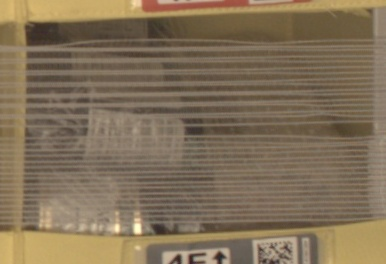

In [14]:
from PIL import Image
img = Image.open(img_path)
print("Selected image:", img_path)
print("True label:", true_label)
print("Endpoint result:", result['predicted_label'])
img

In [15]:
# 7) Cleanup (VERY IMPORTANT)
def safe_call(fn, **kwargs):
    try:
        return fn(**kwargs)
    except ClientError as e:
        code = e.response.get("Error", {}).get("Code", "")
        msg = e.response.get("Error", {}).get("Message", "")
        # If it was already deleted / not found, ignore
        if code in ("ValidationException", "ResourceNotFound", "ResourceNotFoundException"):
            print(f"⚠️ Skipped (already gone): {fn.__name__} -> {msg}")
            return None
        raise

# 1) Discover linked resources
ep_desc = safe_call(sm.describe_endpoint, EndpointName=endpoint_name)
endpoint_config_name = ep_desc["EndpointConfigName"] if ep_desc else None

model_names = []
if endpoint_config_name:
    epc_desc = safe_call(sm.describe_endpoint_config, EndpointConfigName=endpoint_config_name)
    if epc_desc:
        model_names = sorted({pv["ModelName"] for pv in epc_desc.get("ProductionVariants", [])})

print("Cleanup targets:")
print(" - Endpoint:", endpoint_name)
print(" - EndpointConfig:", endpoint_config_name)
print(" - Model(s):", model_names)

# 2) Delete endpoint (and wait)
safe_call(sm.delete_endpoint, EndpointName=endpoint_name)

try:
    waiter = sm.get_waiter("endpoint_deleted")
    waiter.wait(EndpointName=endpoint_name)
    print("✅ Endpoint deleted:", endpoint_name)
except Exception as e:
    print("⚠️ Endpoint delete wait skipped/failed (often OK):", str(e))

# 3) Delete endpoint config
if endpoint_config_name:
    safe_call(sm.delete_endpoint_config, EndpointConfigName=endpoint_config_name)
    print("✅ Endpoint config deleted:", endpoint_config_name)

# 4) Delete model(s)
#for mn in model_names:
#    safe_call(sm.delete_model, ModelName=mn)
#    print("✅ Model deleted:", mn)

print("✅ Cleanup complete.")

Cleanup targets:
 - Endpoint: cbc-ddp-ep-251226062251
 - EndpointConfig: cbc-ddp-ep-251226062251
 - Model(s): ['pytorch-inference-2025-12-26-06-24-57-070']
✅ Endpoint deleted: cbc-ddp-ep-251226062251
✅ Endpoint config deleted: cbc-ddp-ep-251226062251
✅ Cleanup complete.


### Evaluate the **best trained model artifact** offline on the **test split**, generate **report-ready metrics** (accuracy, macro-F1, precision/recall), **confusion matrix**, and **save artifacts** (metrics.json + confusion_matrix.png + optional per-class report) locally and/or to S3.

#### Setup & Config (paths + job/model references)

**What this cell does**
- Sets constants for your run (S3 locations + local temp paths).
- Creates boto3 clients.
- Creates a clean working directory to download/extract the model.

**Why it matters**
- Keeps everything reproducible and avoids hardcoding in multiple cells.


In [9]:
import tarfile
BEST_TRAINING_JOB = "cbc-ddp-251225173021"
WORKDIR = Path("local_eval")
MODEL_DIR = WORKDIR / "model"
MODEL_DIR.mkdir(parents=True, exist_ok=True)
sm = boto3.client("sagemaker", region_name=region)
s3 = boto3.client("s3", region_name=region)

print("✅ Region:", region)
print("✅ Workdir:", WORKDIR.resolve())
print("✅ Training job:", BEST_TRAINING_JOB)

✅ Region: us-east-1
✅ Workdir: /home/sagemaker-user/local_eval
✅ Training job: cbc-ddp-251225173021


### Fetch Model Artifact from Training Job + Download + Extract

**What this cell does**

- Reads the training job to get the ModelArtifacts.S3ModelArtifacts
- Downloads the model tar.gz locally
- Extracts it into a folder so we can load model.pth

**Why it matters**

evaluation is offline, so we load the trained weights directly.

In [10]:
# 1) Describe training job -> get model tar.gz S3 URI
desc = sm.describe_training_job(TrainingJobName=BEST_TRAINING_JOB)
MODEL_TAR_S3 = desc["ModelArtifacts"]["S3ModelArtifacts"]

print("✅ Model tar.gz from training job:", MODEL_TAR_S3)

# 2) Parse bucket/key
assert MODEL_TAR_S3.startswith("s3://"), "Model artifact must be an s3:// URI"
_, _, bucket, *key_parts = MODEL_TAR_S3.split("/")
key = "/".join(key_parts)

# 3) Download
local_tar = MODEL_DIR / "model.tar.gz"
s3.download_file(bucket, key, str(local_tar))
print("✅ Downloaded to:", local_tar)

# 4) Extract
with tarfile.open(local_tar, "r:gz") as tar:
    tar.extractall(path=MODEL_DIR)

print("✅ Extracted contents:")
for p in sorted(MODEL_DIR.glob("**/*")):
    if p.is_file():
        print(" -", p.relative_to(MODEL_DIR))

✅ Model tar.gz from training job: s3://sagemaker-us-east-1-354600943736/cbc-ddp-251225173021/output/model.tar.gz
✅ Downloaded to: local_eval/model/model.tar.gz


/tmp/ipykernel_2024/317143951.py:19: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall(path=MODEL_DIR)


✅ Extracted contents:
 - metrics.json
 - model.pth
 - model.tar.gz


### Load the Model Locally (ResNet50 + state_dict)

**What this cell does**

- Recreates the same network architecture used in training (ResNet50 classifier head)
- Loads the saved model.pth weights from extracted artifact
- Moves model to device (GPU if present else CPU)
- Switches to eval mode

**Why it matters**

Ensures evaluation uses the exact model you trained, without needing an endpoint.

In [11]:
import torch
import torch.nn as nn
from torchvision import models

# Adjust if your training used a different number of classes
NUM_CLASSES = 5

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("✅ Using device:", device)

# Build the same model architecture (ResNet50 backbone + custom head)
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
in_features = model.fc.in_features
model.fc = nn.Linear(in_features, NUM_CLASSES)

# Load weights
model_pth = MODEL_DIR / "model.pth"
assert model_pth.exists(), f"model.pth not found at {model_pth}"

state = torch.load(model_pth, map_location=device)
model.load_state_dict(state)
model.to(device)
model.eval()

print("✅ Loaded model weights:", model_pth)

✅ Using device: cpu
✅ Loaded model weights: local_eval/model/model.pth


### Build Test DataLoader (same preprocessing)

**What this cell does**

- Loads the test split from your local folder local_data/splits/test
- Applies ImageNet normalization to match ResNet pretraining
- Builds a DataLoader for evaluation

**Why it matters**

If transforms don’t match training/inference, results will be wrong.

In [12]:
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder

TEST_DIR = Path("local_data/splits/test")
assert TEST_DIR.exists(), f"Test dir not found: {TEST_DIR}"

# Typical ImageNet transforms for ResNet50
test_tfms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

test_ds = ImageFolder(root=str(TEST_DIR), transform=test_tfms)
test_loader = DataLoader(test_ds, batch_size=64, shuffle=False, num_workers=2)

print("✅ Test samples:", len(test_ds))
print("✅ Class labels:", test_ds.classes)
print("✅ Class->index:", test_ds.class_to_idx)

✅ Test samples: 1049
✅ Class labels: ['1', '2', '3', '4', '5']
✅ Class->index: {'1': 0, '2': 1, '3': 2, '4': 3, '5': 4}


### Run Evaluation + Compute Metrics (Accuracy, Macro-F1, Precision, Recall)

**What this cell does**

- Runs forward passes on all test images
- Collects true labels + predictions
- Computes:
    1. Accuracy
    2. Macro Precision / Recall / F1
- Prints a report-friendly summary

**Why it matters**

Macro metrics are important for class imbalance and rubric-style reporting.

In [13]:
import numpy as np
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    confusion_matrix,
    classification_report,
)

y_true = []
y_pred = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        yb = yb.to(device)

        logits = model(xb)
        preds = torch.argmax(logits, dim=1)

        y_true.extend(yb.cpu().numpy().tolist())
        y_pred.extend(preds.cpu().numpy().tolist())

acc = float(accuracy_score(y_true, y_pred))
prec, rec, f1, _ = precision_recall_fscore_support(
    y_true, y_pred, average="macro", zero_division=0
)

metrics = {
    "test_accuracy": float(acc),
    "test_macro_precision": float(prec),
    "test_macro_recall": float(rec),
    "test_macro_f1": float(f1),
    "num_test_samples": int(len(y_true)),
    "class_labels": test_ds.classes,
}

print("=== ✅ Milestone 10 Evaluation Metrics ===")
for k, v in metrics.items():
    print(f"{k}: {v}")

print("\n=== ✅ Classification Report (per class) ===")
print(classification_report(y_true, y_pred, target_names=test_ds.classes, zero_division=0))


=== ✅ Milestone 10 Evaluation Metrics ===
test_accuracy: 0.3393708293612965
test_macro_precision: 0.41481308857605015
test_macro_recall: 0.3361547501263552
test_macro_f1: 0.3524913306918365
num_test_samples: 1049
class_labels: ['1', '2', '3', '4', '5']

=== ✅ Classification Report (per class) ===
              precision    recall  f1-score   support

           1       0.70      0.32      0.44       124
           2       0.37      0.31      0.34       231
           3       0.27      0.29      0.28       268
           4       0.30      0.48      0.37       238
           5       0.44      0.28      0.34       188

    accuracy                           0.34      1049
   macro avg       0.41      0.34      0.35      1049
weighted avg       0.38      0.34      0.34      1049



### Confusion Matrix Plot (Report-ready PNG)

**What this cell does**
- Computes confusion matrix
- Saves a clean heatmap-style plot as confusion_matrix.png

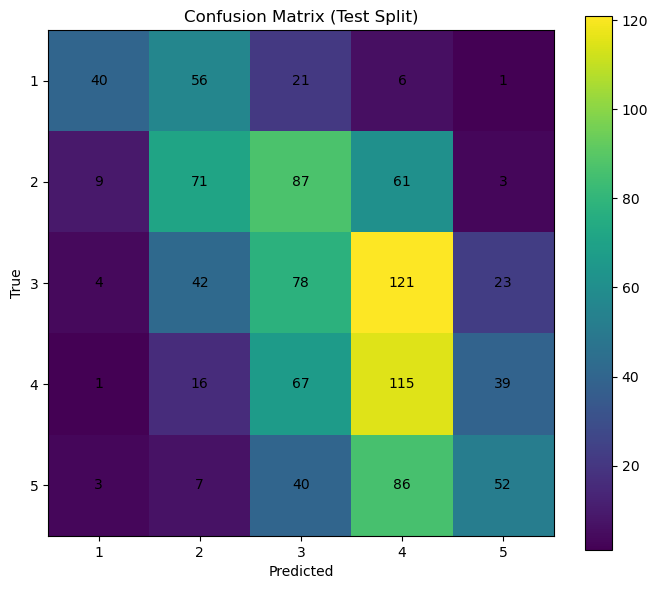

✅ Saved: local_eval/confusion_matrix.png


In [14]:
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)

fig = plt.figure(figsize=(7, 6))
plt.imshow(cm, interpolation="nearest")
plt.title("Confusion Matrix (Test Split)")
plt.colorbar()
tick_marks = np.arange(len(test_ds.classes))
plt.xticks(tick_marks, test_ds.classes)
plt.yticks(tick_marks, test_ds.classes)
plt.xlabel("Predicted")
plt.ylabel("True")

# annotate counts
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, str(cm[i, j]), ha="center", va="center")

out_png = WORKDIR / "confusion_matrix.png"
plt.tight_layout()
plt.savefig(out_png, dpi=200)
plt.show()

print("✅ Saved:", out_png)


### Save Metrics to JSON (Report + Reproducibility)
- Writes the metric dictionary to metrics.json
- Easy to attach to GitHub and reference in documentation.

In [15]:
out_json = WORKDIR / "metrics.json"
with open(out_json, "w") as f:
    json.dump(metrics, f, indent=2)

print("✅ Saved:", out_json)
print(json.dumps(metrics, indent=2))

✅ Saved: local_eval/metrics.json
{
  "test_accuracy": 0.3393708293612965,
  "test_macro_precision": 0.41481308857605015,
  "test_macro_recall": 0.3361547501263552,
  "test_macro_f1": 0.3524913306918365,
  "num_test_samples": 1049,
  "class_labels": [
    "1",
    "2",
    "3",
    "4",
    "5"
  ]
}


### Upload Milestone 10 Artifacts to S3 Output Folder
- Uploads metrics.json and confusion_matrix.png to S3 output prefix
- Keeps all run outputs stored centrally

In [17]:
OUTPUT_PREFIX = "capstone-bin-count/20251225-063820/output/local_eval/"
OUTPUT_BUCKET = "sagemaker-us-east-1-354600943736"

def upload_file(local_path: Path, bucket: str, key: str):
    s3.upload_file(str(local_path), bucket, key)
    return f"s3://{bucket}/{key}"

uploaded = {}
uploaded["metrics_json"] = upload_file(out_json, OUTPUT_BUCKET, OUTPUT_PREFIX + "metrics.json")
uploaded["confusion_matrix_png"] = upload_file(out_png, OUTPUT_BUCKET, OUTPUT_PREFIX + "confusion_matrix.png")

print("✅ Uploaded artifacts:")
for k, v in uploaded.items():
    print(f"{k}: {v}")

✅ Uploaded artifacts:
metrics_json: s3://sagemaker-us-east-1-354600943736/capstone-bin-count/20251225-063820/output/local_eval/metrics.json
confusion_matrix_png: s3://sagemaker-us-east-1-354600943736/capstone-bin-count/20251225-063820/output/local_eval/confusion_matrix.png


## Deploy DDP-trained model for real-time inference

In this step, we deploy the **DDP-trained model artifact** from the completed training job to a **real-time SageMaker endpoint**, run a **single inference smoke test**, and then **clean up** the endpoint resources to avoid cost.

We fetch the **training image URI** and **model artifact S3 URI** directly from the training job description to ensure deployment uses a compatible container and artifact layout.

P.S. - ignore/remove the duplicate imports added due to kernel failure

In [19]:
from botocore.exceptions import ClientError
import json
import time
import random
from pathlib import Path

import boto3
import sagemaker
from sagemaker.pytorch.model import PyTorchModel
from sagemaker.serializers import IdentitySerializer
from sagemaker.deserializers import JSONDeserializer

# ==========
# REQUIRED: set your completed DDP training job name
# ==========
DDP_TRAINING_JOB = "cbc-ddp-251225173021"

sess = sagemaker.Session()
region = sess.boto_region_name
role = sagemaker.get_execution_role()
sm = boto3.client("sagemaker", region_name=region)

# 1) Pull model artifact + training image from the training job
desc = sm.describe_training_job(TrainingJobName=DDP_TRAINING_JOB)
MODEL_ARTIFACT = desc["ModelArtifacts"]["S3ModelArtifacts"]
TRAINING_IMAGE = desc["AlgorithmSpecification"]["TrainingImage"]

print("Model artifact:", MODEL_ARTIFACT)
print("Training image:", TRAINING_IMAGE)

# 2) Choose an endpoint name (short + unique)
ts = time.strftime("%y%m%d%H%M%S")
endpoint_name = f"cbc-ddp-ep-{ts}"
print("Endpoint name:", endpoint_name)

# 3) IMPORTANT:
# Ensure you have an inference script file in your notebook working directory.
ENTRY_POINT = "final_inference.py"  # must exist locally
SOURCE_DIR = "."                    # directory containing ENTRY_POINT

# 4) Create model object using the DDP model artifact
pt_model = PyTorchModel(
    model_data=MODEL_ARTIFACT,
    role=role,
    entry_point=ENTRY_POINT,
    source_dir=SOURCE_DIR,
    framework_version="2.1.0",
    py_version="py310",
)

# 5) Deploy endpoint
predictor = pt_model.deploy(
    initial_instance_count=1,
    instance_type="ml.g4dn.xlarge",
    endpoint_name=endpoint_name
)

# Serializer/deserializer for RAW image bytes -> JSON output
predictor.serializer = IdentitySerializer(content_type="application/x-image")
predictor.deserializer = JSONDeserializer()
print("✅ Endpoint InService:", endpoint_name)

# 6) Invoke smoke test
test_root = Path("local_data/splits/test")
all_imgs = list(test_root.glob("*/*.jpg"))
if len(all_imgs) == 0:
    raise FileNotFoundError("No test images found at local_data/splits/test/<class>/*.jpg")

img_path = random.choice(all_imgs)
true_label = img_path.parent.name
print("Selected image:", img_path)
print("True label:", true_label)

with open(img_path, "rb") as f:
    img_bytes = f.read()

result = predictor.predict(img_bytes)
print("Endpoint result:", result)

# OPTIONAL: keep endpoint for Lambda testing
# If you plan to test Lambda, do NOT delete the endpoint now.
# Save endpoint_name somewhere safe:
print("\n✅ SAVE THIS for Lambda ENV VAR ENDPOINT_NAME:", endpoint_name)

Model artifact: s3://sagemaker-us-east-1-354600943736/cbc-ddp-251225173021/output/model.tar.gz
Training image: 763104351884.dkr.ecr.us-east-1.amazonaws.com/pytorch-training:2.1.0-gpu-py310
Endpoint name: cbc-ddp-ep-251226080355
---------!✅ Endpoint InService: cbc-ddp-ep-251226080355
Selected image: local_data/splits/test/4/104121.jpg
True label: 4
Endpoint result: {'predicted_label': '3', 'predicted_index': 2, 'confidence': 0.29653242230415344, 'probabilities': [0.04244561120867729, 0.1271975040435791, 0.29653242230415344, 0.28260692954063416, 0.2512175440788269], 'class_labels': ['1', '2', '3', '4', '5']}

✅ SAVE THIS for Lambda ENV VAR ENDPOINT_NAME: cbc-ddp-ep-251226080355


## Create Lambda function to invoke the SageMaker endpoint

In this step, we create an AWS Lambda function that:
1. Accepts an input event containing either:
   - `image_url` (public HTTP/HTTPS URL), OR
   - `s3_uri` (private S3 object path like s3://bucket/key.jpg)
2. Downloads the image bytes
3. Invokes the SageMaker endpoint using:
   - ContentType = application/x-image
   - Body = raw image bytes
4. Returns the model prediction as JSON

### Steps (AWS Console)

### A) Ensure your endpoint is deployed and running
- You must have the endpoint **InService**
- Copy the endpoint name (from the deployment cell output)

### B) Create a Lambda execution role (IAM)
Create a role with these permissions:
1) SageMaker runtime invoke permission:
- Action: `sagemaker:InvokeEndpoint`
- Resource: your endpoint ARN

2) If using S3 inputs (`s3_uri`):
- Action: `s3:GetObject`
- Resource: `arn:aws:s3:::<your-bucket>/*`

AWS-managed policy shortcuts (acceptable for capstone, but not least-privilege):
- `AmazonSageMakerFullAccess` (invocation)
- `AmazonS3ReadOnlyAccess` (if using s3_uri)

### C) Create Lambda function
- Runtime: Python 3.10 (recommended)
- Name: e.g., `cbc-invoke-endpoint`
- Execution role: the role created above

### D) Add Environment Variable
In Lambda configuration → Environment variables:
- `ENDPOINT_NAME` = your deployed endpoint name (e.g., cbc-ddp-ep-251226062251)

### E) Paste the Lambda code into the Lambda editor and Deploy
Then test using the sample events below.

### Sample Test Events
1) HTTP URL:
{
  "image_url": "https://aft-vbi-pds.s3.amazonaws.com/bin-images/100313.jpg"
}

2) S3 URI:
{
  "s3_uri": "s3://your-bucket/path/to/image.jpg"
}

3) API Gateway style:
{
  "body": "{\"image_url\": \"https://aft-vbi-pds.s3.amazonaws.com/bin-images/100313.jpg\"}"
}

In [22]:
# Lambda Funtion deployed and tested for all 3 test events

"""
Status: Succeeded
Test Event Name: S3_URI

Response:
{
  "statusCode": 200,
  "headers": {
    "Content-Type": "application/json",
    "Access-Control-Allow-Origin": "*"
  },
  "body": "{\"endpoint\": \"cbc-ddp-ep-251226080355\", \"input\": {\"s3_uri\": \"s3://sagemaker-us-east-1-354600943736/capstone-bin-count/20251225-063820/data/test/3/00198.jpg\"}, \"result\": {\"predicted_label\": \"3\", \"predicted_index\": 2, \"confidence\": 0.36123961210250854, \"probabilities\": [0.027744213119149208, 0.1155814602971077, 0.36123961210250854, 0.29383385181427, 0.2016008496284485], \"class_labels\": [\"1\", \"2\", \"3\", \"4\", \"5\"]}}"
}


Status: Succeeded
Test Event Name: HTTP_URL

Response:
{
  "statusCode": 200,
  "headers": {
    "Content-Type": "application/json",
    "Access-Control-Allow-Origin": "*"
  },
  "body": "{\"endpoint\": \"cbc-ddp-ep-251226080355\", \"input\": {\"image_url\": \"https://aft-vbi-pds.s3.amazonaws.com/bin-images/100313.jpg\"}, \"result\": {\"predicted_label\": \"5\", \"predicted_index\": 4, \"confidence\": 0.42535266280174255, \"probabilities\": [0.03387201204895973, 0.09150319546461105, 0.20357608795166016, 0.245696023106575, 0.42535266280174255], \"class_labels\": [\"1\", \"2\", \"3\", \"4\", \"5\"]}}"
}

Status: Succeeded
Test Event Name: API_Gateway_style

Response:
{
  "statusCode": 200,
  "headers": {
    "Content-Type": "application/json",
    "Access-Control-Allow-Origin": "*"
  },
  "body": "{\"endpoint\": \"cbc-ddp-ep-251226080355\", \"input\": {\"image_url\": \"https://aft-vbi-pds.s3.amazonaws.com/bin-images/100313.jpg\"}, \"result\": {\"predicted_label\": \"5\", \"predicted_index\": 4, \"confidence\": 0.42535266280174255, \"probabilities\": [0.03387201204895973, 0.09150319546461105, 0.20357608795166016, 0.245696023106575, 0.42535266280174255], \"class_labels\": [\"1\", \"2\", \"3\", \"4\", \"5\"]}}"
}

"""
print("Now we can deleted the endpoint to stop unnecessary resource usage")

Now we can deleted the endpoint to stop unnecessary resource usage


## Final cleanup: delete SageMaker endpoint + endpoint config + model

This step prevents ongoing real-time hosting charges by deleting:
1) Endpoint
2) Endpoint Configuration
3) Model resource(s)

It is safe to run multiple times (handles "not found" cases).

In [23]:
ENDPOINT_NAME = "cbc-ddp-ep-251226080355"
def _safe_delete(fn, label: str, **kwargs):
    try:
        fn(**kwargs)
        print(f"✅ Deleted {label}: {list(kwargs.values())[0]}")
    except ClientError as e:
        code = e.response["Error"].get("Code", "")
        if code in ["ValidationException", "ResourceNotFound"]:
            print(f"ℹ️ Already gone / not found ({label}): {list(kwargs.values())[0]}")
        else:
            raise

# 1) Find endpoint config + models referenced by the endpoint config
endpoint_desc = sm.describe_endpoint(EndpointName=ENDPOINT_NAME)
endpoint_config_name = endpoint_desc["EndpointConfigName"]

cfg = sm.describe_endpoint_config(EndpointConfigName=endpoint_config_name)
model_names = [pv["ModelName"] for pv in cfg["ProductionVariants"]]

print("Cleanup targets:")
print(" - Endpoint:", ENDPOINT_NAME)
print(" - EndpointConfig:", endpoint_config_name)
print(" - Model(s):", model_names)

# 2) Delete endpoint first
_safe_delete(sm.delete_endpoint, "Endpoint", EndpointName=ENDPOINT_NAME)

# 3) Delete endpoint config
_safe_delete(sm.delete_endpoint_config, "EndpointConfig", EndpointConfigName=endpoint_config_name)

Cleanup targets:
 - Endpoint: cbc-ddp-ep-251226080355
 - EndpointConfig: cbc-ddp-ep-251226080355
 - Model(s): ['pytorch-inference-2025-12-26-08-06-12-532']
✅ Deleted Endpoint: cbc-ddp-ep-251226080355
✅ Deleted EndpointConfig: cbc-ddp-ep-251226080355


In [24]:
print("✅ Cleanup complete.")


✅ Cleanup complete.


## Conclusion

In this capstone project, I designed and implemented an end-to-end **computer vision inference pipeline on Amazon SageMaker** for a **5-class image classification** problem. The work covered the full ML lifecycle — **data preparation, model training, hyperparameter tuning, distributed training, real-time deployment, and serverless invocation** — with a strong emphasis on repeatability and cost-aware engineering.

### What was built (end-to-end)
- **Baseline transfer-learning model (ResNet-50)** trained on the prepared dataset splits (train/val/test) and evaluated using **accuracy + macro-F1** to reflect multi-class performance fairly.
- **Hyperparameter Optimization (HPO)** to improve validation macro-F1 beyond the initial baseline by tuning learning rate, weight decay, batch size, training epochs, etc.
- **Distributed Data Parallel (DDP)** training on SageMaker to validate scalable training patterns and multi-node setup.
- **Real-time inference endpoint** deployed from the final trained model artifact and validated with a smoke test.
- **AWS Lambda integration** to invoke the endpoint using:
  - Direct **HTTP image URLs**
  - **S3 URLs/paths**
  - **API Gateway-style events**
- **Cost control and resource hygiene** by systematically deleting endpoints, endpoint configs, and models after testing (SageMaker real-time inference resources incur ongoing instance-based cost while running). 

### Key outcome
This project demonstrates a production-style deployment flow: **train → tune → scale → deploy → invoke → cleanup**, showing how a model can be served through both direct real-time inference and a **serverless API layer (Lambda)**.

### Next improvements (recommended for real-world readiness)
- Improve accuracy/macro-F1 via **stronger augmentation**, **class-balancing strategies**, **longer training**, and **fine-tuning deeper layers**.
- Add **monitoring + drift detection**, structured logging, and systematic evaluation across diverse samples.
- Introduce a **Model Registry / CI pipeline** so retraining and deployment can be automated safely.

---

**Brejesh Balakrishnan**  
LinkedIn: [Click Here!](https://www.linkedin.com/in/brejesh-balakrishnan-7855051b9/)